In [1]:
%matplotlib inline

import sys
sys.path.append("..")

In [2]:
from functions_sqoop import *
from vr.models.shnmn import _shnmn_func
from torch.autograd import Variable
import torch.nn.functional as F
from vr.utils import load_execution_engine, load_program_generator
from train_model import get_execution_engine
from vr.utils import load_vocab
from vr.data import ClevrDataset, ClevrDataLoader
from train_model import check_accuracy

## We consider here the results for NMN tree models w residual modules trained on scenes w 2 and 5 objects 
We want to consider here the tuples that were in the test set and modify the distance between objects.

In [3]:
root_path = './../../..'

In [4]:
results_path = {2: join(root_path, 'systematic-generalization-sqoop_2objects/results/tree_models_2objs'),
                5: join(root_path, 'systematic-generalization-sqoop/results/tree_models_5objs')}

data_path = {2: join(root_path, 'datasets/sqoop-no_crowding-variety_1-repeats_30000'),
             5: join(root_path, 'datasets/sqoop-variety_1-repeats_30000')}

### specify if you want the dataset with 2 or 5 objects

In [5]:
key = 2 

In [6]:
# load vocabulary and questions

vocab_dataset = load_vocab(join(data_path[key], 'vocab.json'))

question_h5_path = join(data_path[key], 'test_questions.h5') 
question_h5 = h5py.File(question_h5_path, 'r')
question_list = list(question_h5['questions'])

In [7]:
# load the first question in the test set (arbitrary)

id_sample = 0
question_idx = question_list[id_sample]  

question_token = [vocab_dataset['question_idx_to_token'][q_] for q_ in question_idx]
x, r, y = question_token

In [8]:
# this corresponds to the question

question_idx, question_token

(array([22, 45, 31]), ['P', 'above', 'Y'])

In [9]:
uniform_dist = [1.0 / len(vocab) ]*len(vocab)
sampler_class = LongTailSampler(uniform_dist)
test_sampler  = sampler_class(True,  3, vocab)

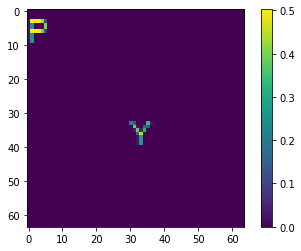

In [10]:
# specify the list of position, x and y

posx = [5, 5]
posy = [35, 35]

obj1 = Object(fontsize=10, angle=0, pos=posx)
obj2 = Object(fontsize=10, angle=0, pos=posy)
obj1.shape = x
obj2.shape = y

seed = 1
rng = np.random.RandomState(seed)
scene = generate_scene_(rng, test_sampler, objects = [obj1, obj2], restrict = True, relation=r)

img = draw_scene_(scene)
img_npy = np.array(img).transpose(2,0,1) / 255
plt.imshow(np.array(img_npy[1]))  # the dataset is generated such that the only active channel is green
plt.colorbar()

## We load and test the model

In [11]:
dct = {'data_dir': join(PATH_DATASET_AT_TRAIN, data_path[key].split('/')[-1]),
       'model_type': 'SHNMN',
       'tau_init': 'tree'
      }

lst_json = retrieve_id_repeated_experiments(slurm_id=None, path_model=results_path[key], args=dct)
lst_slurm_id_tree = retrieve_id_repeated_experiments(lst_json[0].split('.')[0], path_model=results_path[key])

In [12]:
lst_slurm_id_tree

['17364153_2_', '17364143_4_', '17364154_3_', '17364151_0_', '17364152_1_']

In [13]:
# we always trained 5 models (repetitions of the same experiments with different init values)
# we select arbitrarily the first one

model_id = 0

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

tree_model, tree_kwargs = load_execution_engine(join(results_path[key], lst_slurm_id_tree[model_id]+'.pt.best'))

if torch.cuda.is_available():
    tree_model.cuda()
    
tree_model.eval();

using correct initialization
initial alpha 
tensor([[100.,   0.,   0.],
        [  0.,   0., 100.],
        [  0., 100.,   0.]])
initializing with tree.


In [15]:
question_torch = torch.tensor(question_idx)
feats_torch = torch.tensor((np.array(img_npy).reshape(1, 3, 64, 64)).astype('float32'))

In [16]:
question_torch, feats_torch.shape

(tensor([22, 45, 31]), torch.Size([1, 3, 64, 64]))

In [17]:
question_var = Variable(question_torch.to(device))
feats_var = Variable(feats_torch.to(device))

question_embed = tree_model.question_embeddings(question_var)
stem_image = tree_model.stem(feats_var)

print(question_embed.shape, stem_image.shape)

res = _shnmn_func(question=question_embed, 
                  img=stem_image.unsqueeze(1), 
                  num_modules=tree_model.num_modules, 
                  alpha=tree_model.alpha,
                  tau_0=Variable(tree_model.tau_0),
                  tau_1=Variable(tree_model.tau_1), 
                  func=tree_model.func)

torch.Size([3, 82112]) torch.Size([1, 64, 16, 16])


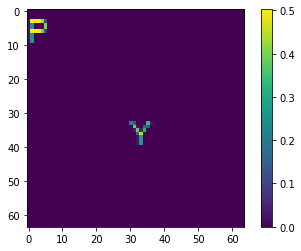

In [18]:
plt.imshow(np.array(img_npy[1]))
plt.colorbar()

0


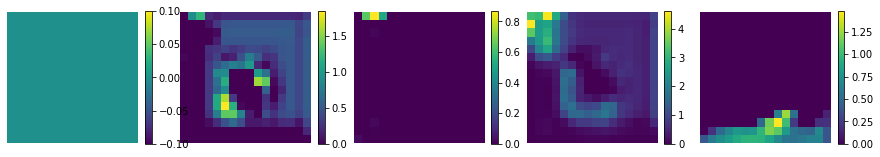

1


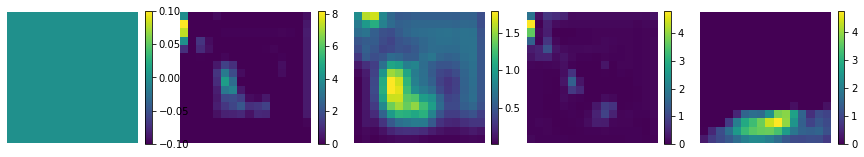

2


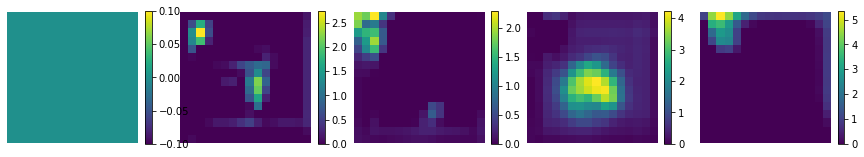

3


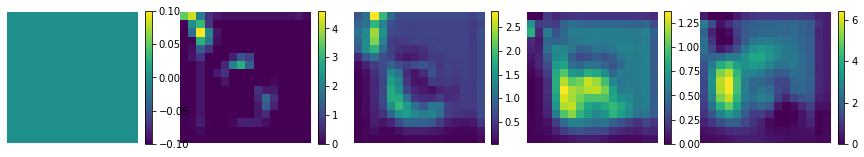

4


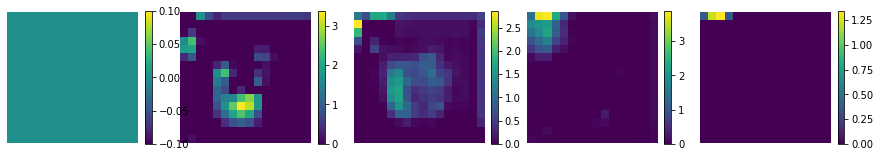

5


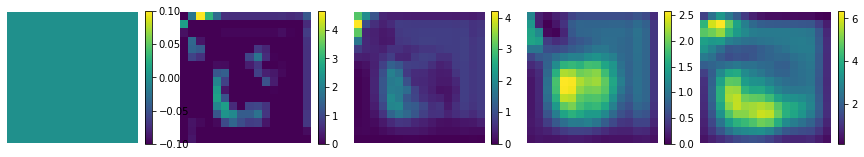

6


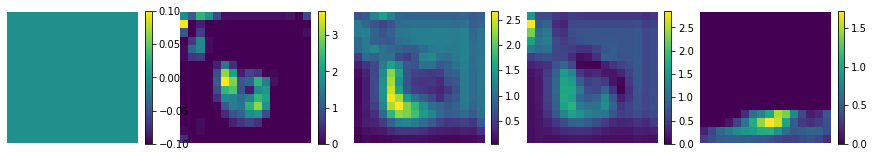

7


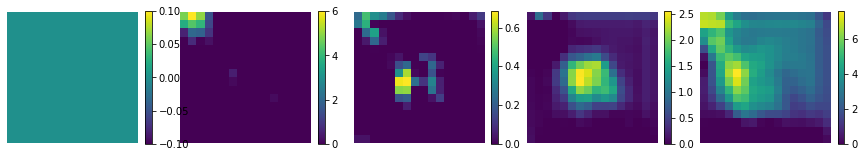

8


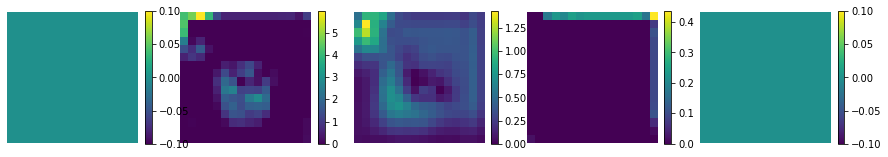

9


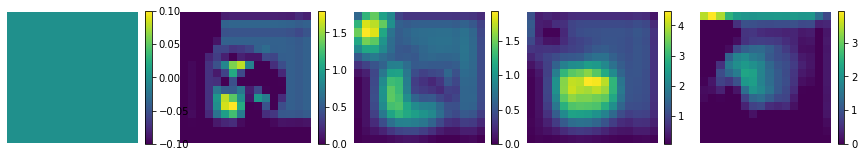

10


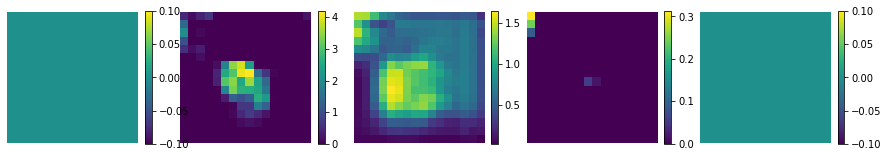

11


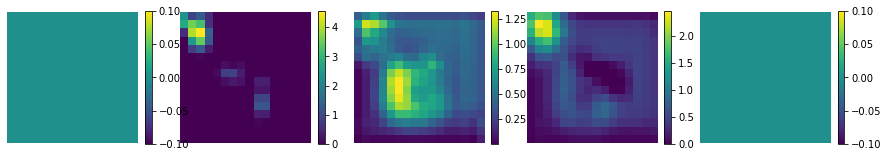

12


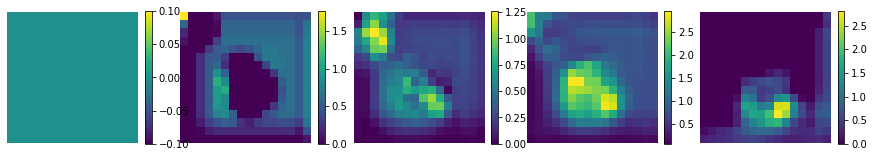

13


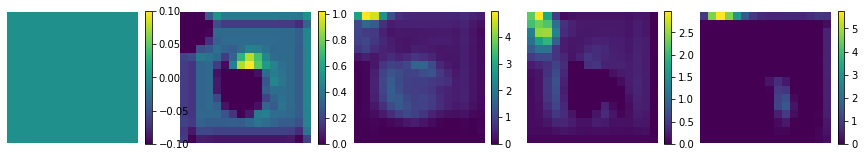

14


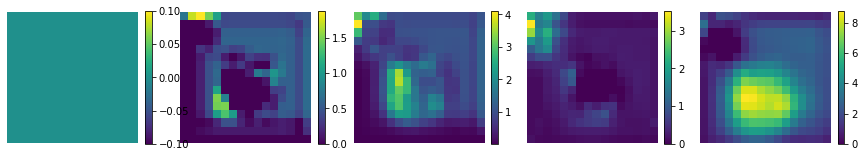

15


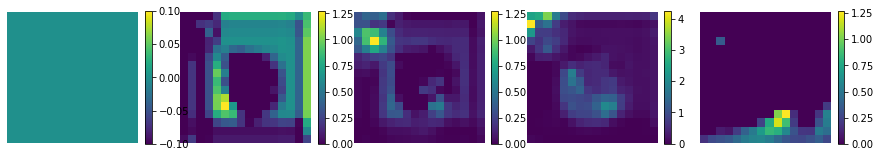

16


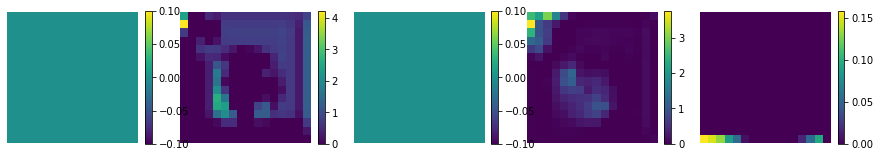

17


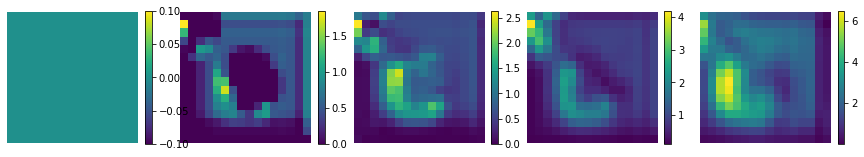

18


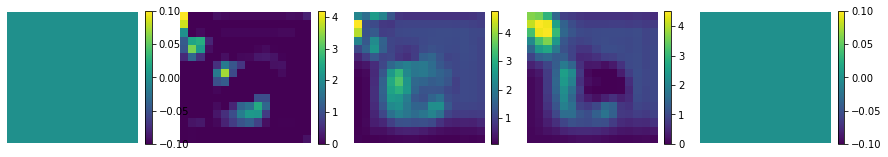

19


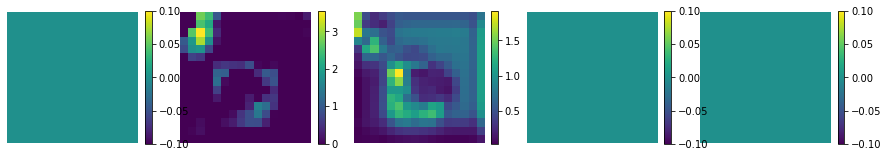

20


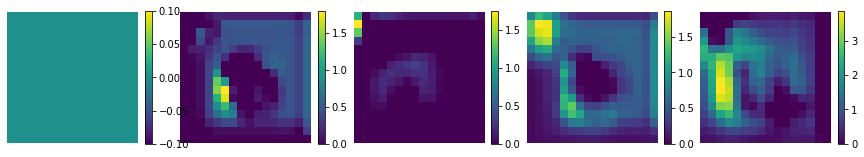

21


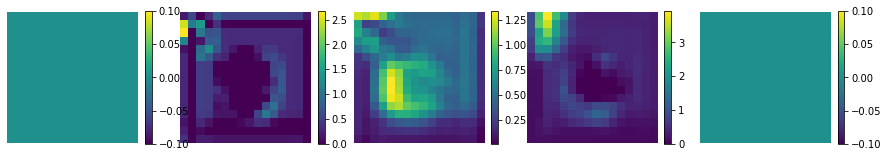

22


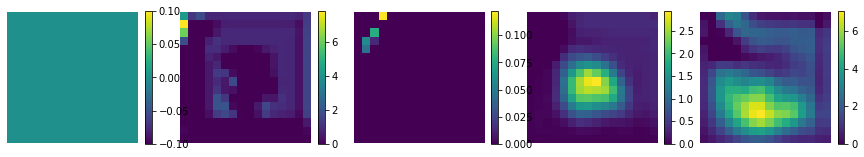

23


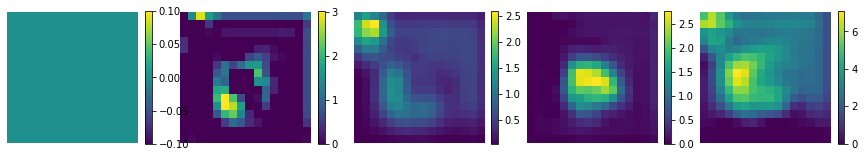

24


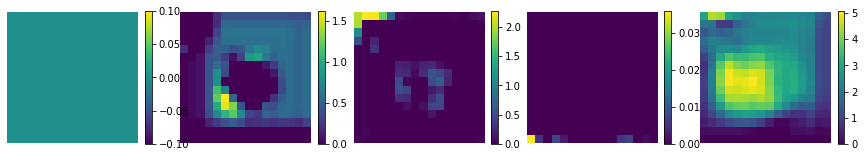

25


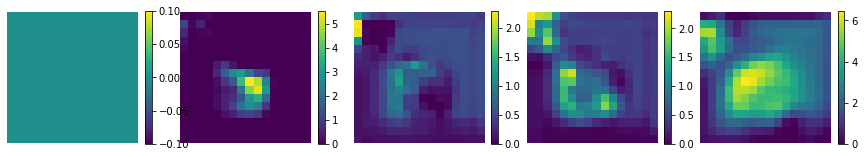

26


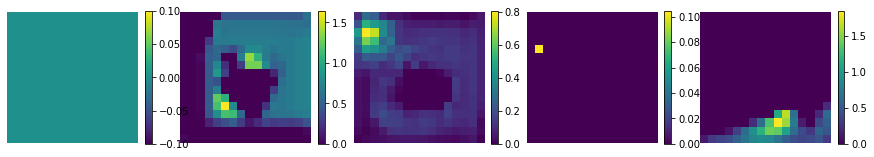

27


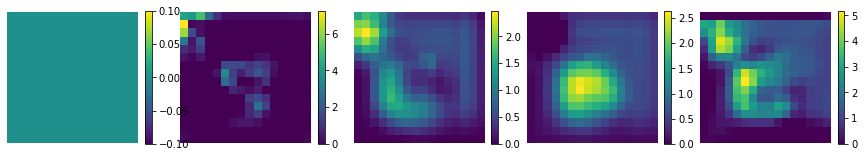

28


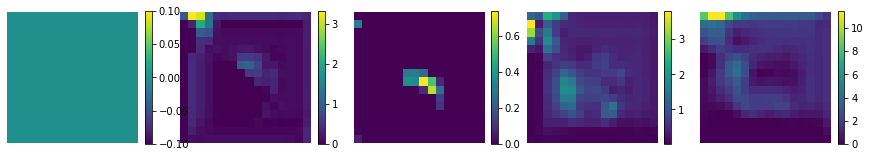

29


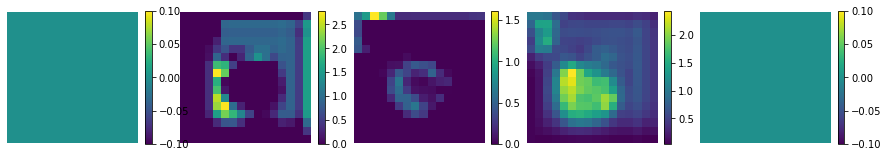

30


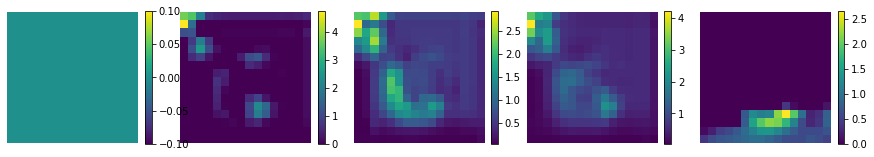

31


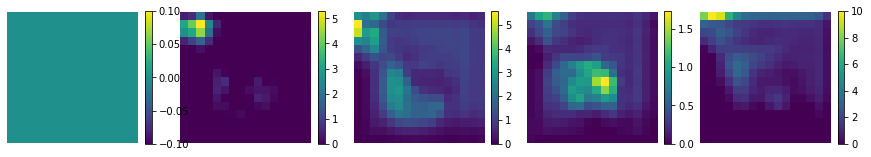

32


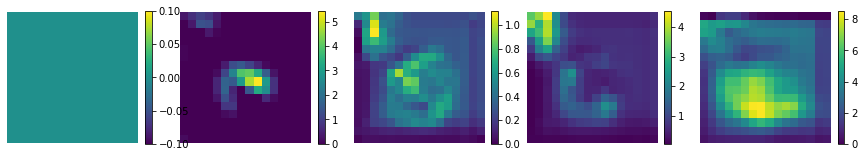

33


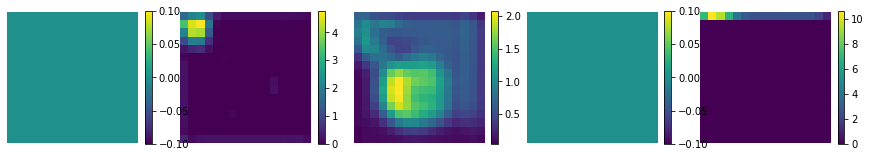

34


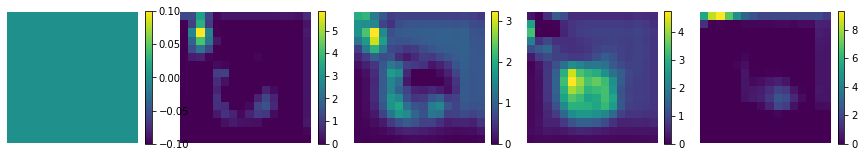

35


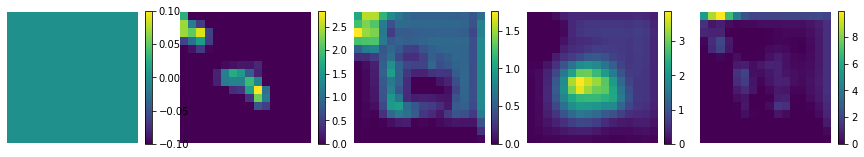

36


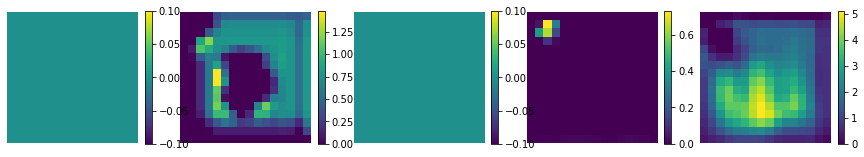

37


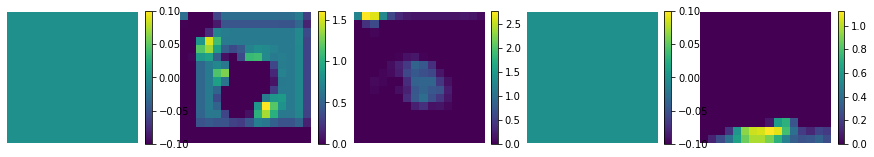

38


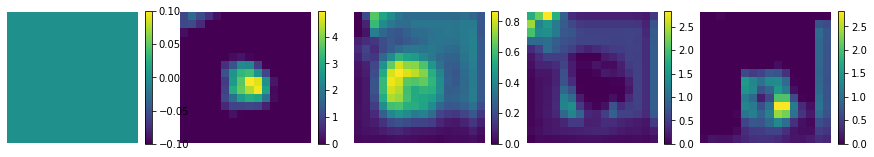

39


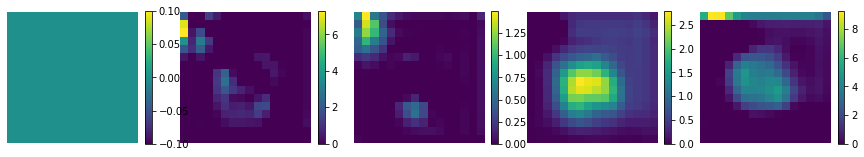

40


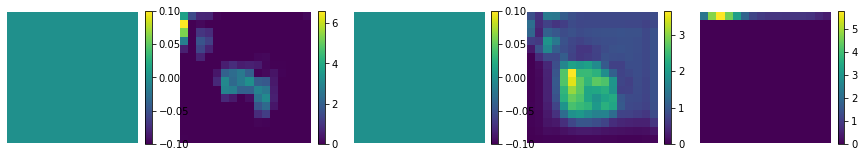

41


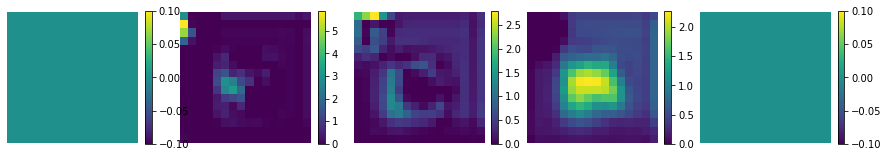

42


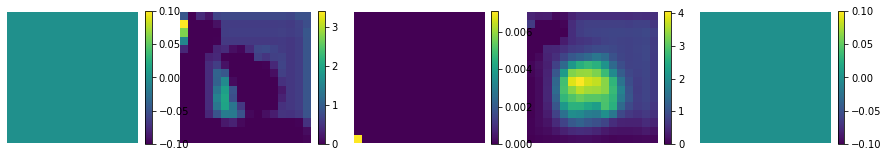

43


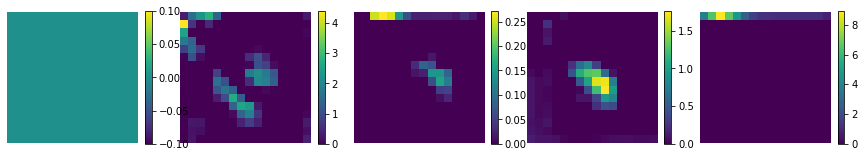

44


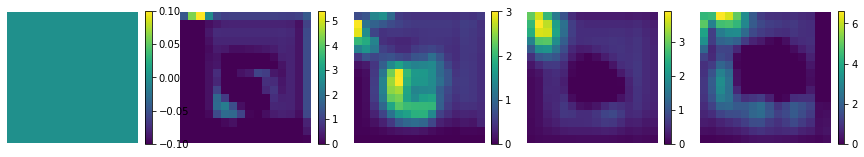

45


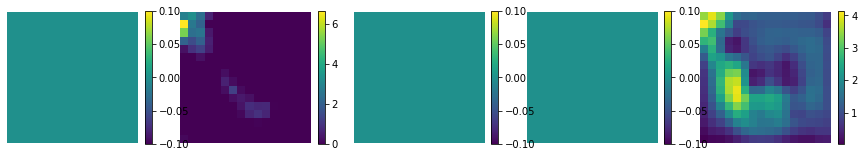

46


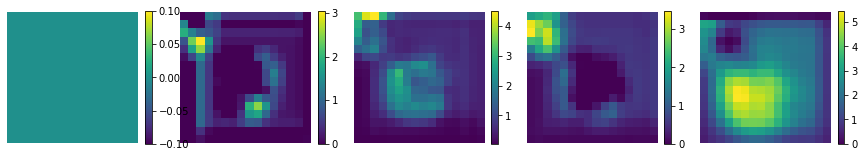

47


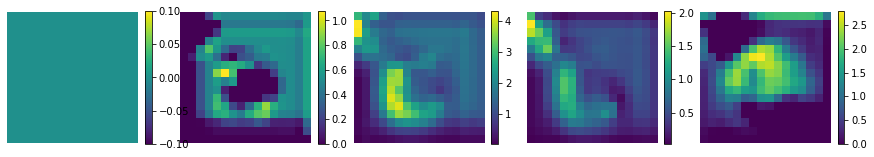

48


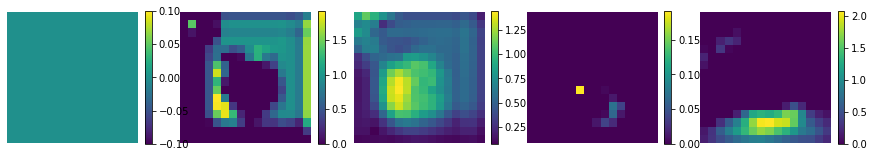

49


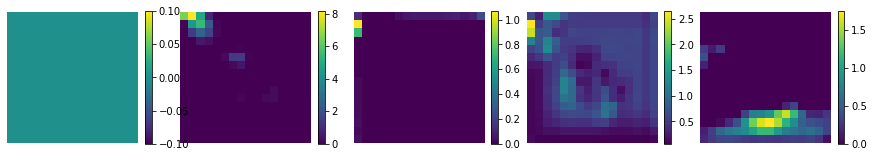

50


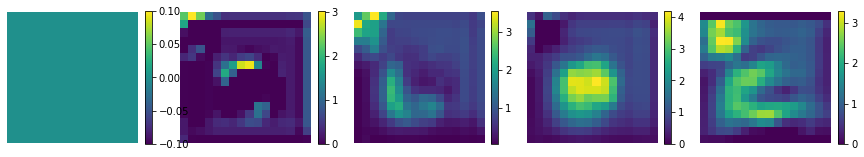

51


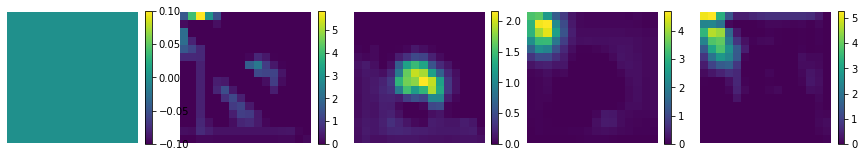

52


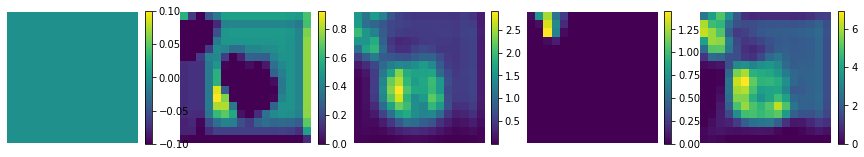

53


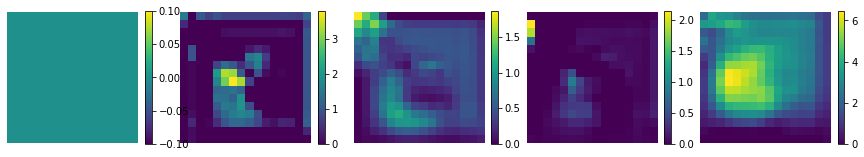

54


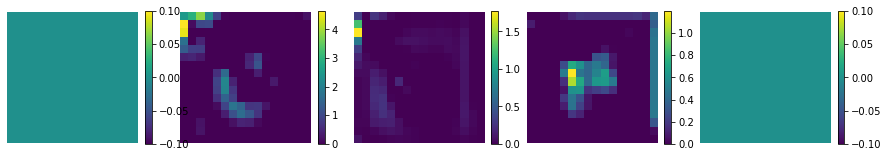

55


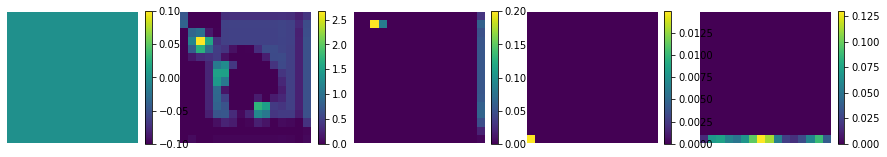

56


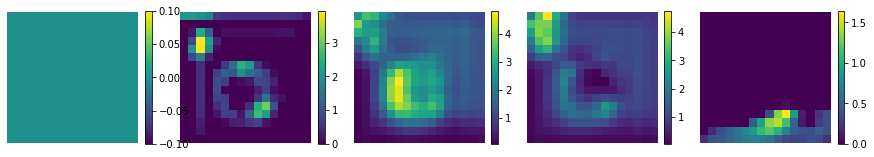

57


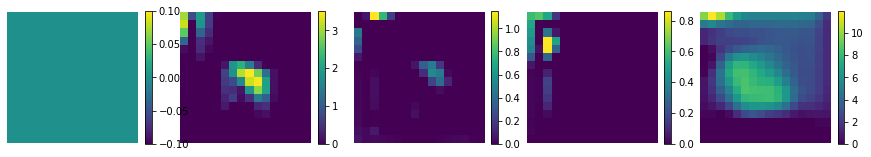

58


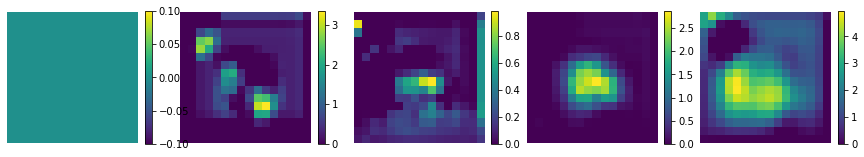

59


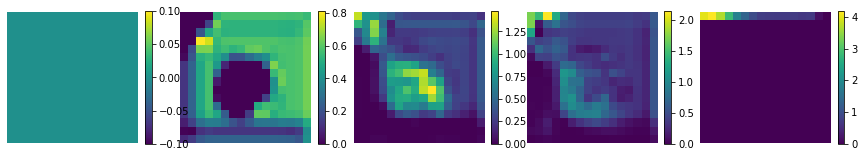

60


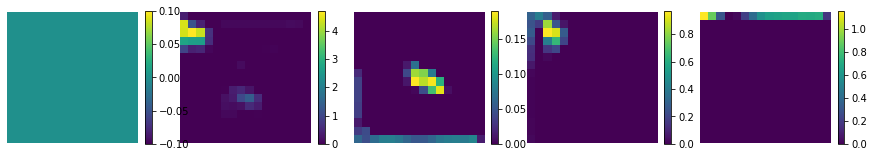

61


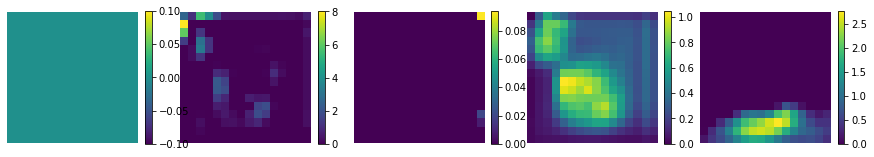

62


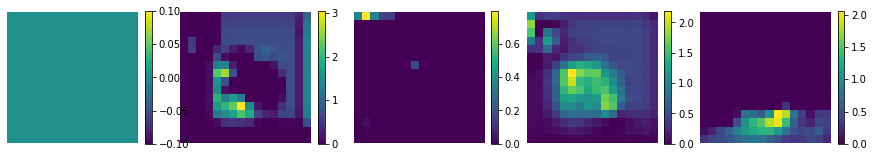

63


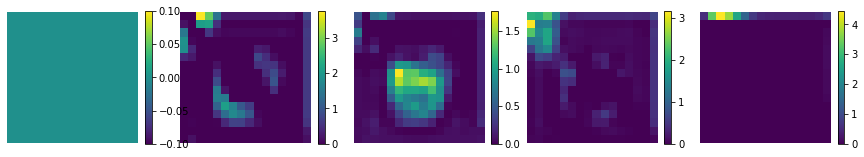

In [19]:
maps = res.cpu().detach().numpy()[0]

for id_map in range(maps.shape[1]):
    print(id_map)
    fig, ax = plt.subplots(figsize=(15, 5), ncols=maps.shape[0])
    for id_module in range(maps.shape[0]): 
        im = ax[id_module].imshow(maps[id_module, id_map])
        plt.colorbar(im, ax=ax[id_module], fraction=0.046)
        ax[id_module].set_axis_off()
    plt.show()

## The following function does the same job of what we have seen above

**X, R, Y**: are the idx for 1st object, relation and 2nd object

**posx**: list of two values containing (x,y) coordinates for 1st object: given the dimensions of the object fixed at 10, it does not make sense to go out of the range [5, 59]

**posy**: same as posx for the 2nd object, avoid overlap

**path_vocab_dataset**: path to the vocabulary

**path_model**: folder containing the results

**model_file**: model name

In [20]:
path_vocab_dataset = join(data_path[key], 'vocab.json')
vocab_dataset = load_vocab(path_vocab_dataset)
path_model = results_path[key]
model_file = lst_slurm_id_tree[id_sample] + '.pt.best'

**NOTE**  

If you want to retrieve questions, making new ones, all you have to do is using the vocab

In [21]:
question_words = ['A', 'right_of', 'D']

question_idx = [vocab_dataset['question_token_to_idx'][q_] for q_ in question_words]
question_token = [vocab_dataset['question_idx_to_token'][q_] for q_ in question_idx]

In [22]:
question_idx, question_token # (relations are right_of, left_of, above, and below)

([7, 44, 10], ['A', 'right_of', 'D'])

using correct initialization
initial alpha 
tensor([[100.,   0.,   0.],
        [  0.,   0., 100.],
        [  0., 100.,   0.]])
initializing with tree.
torch.Size([3, 82112]) torch.Size([1, 64, 16, 16])
0


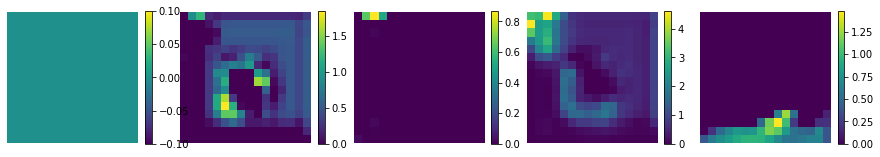

1


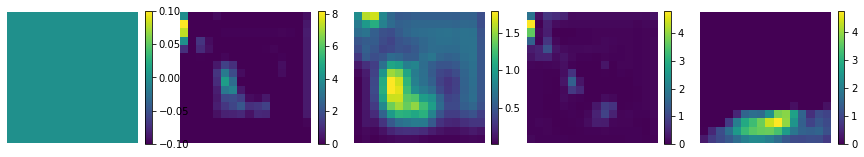

2


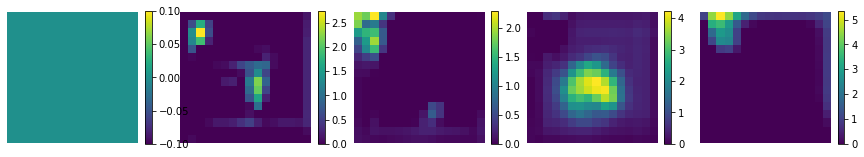

3


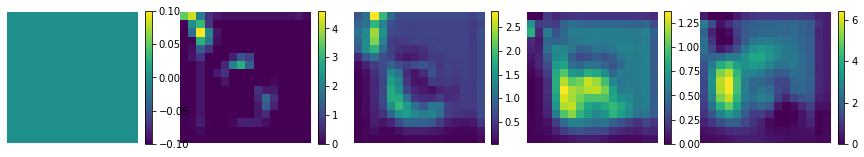

4


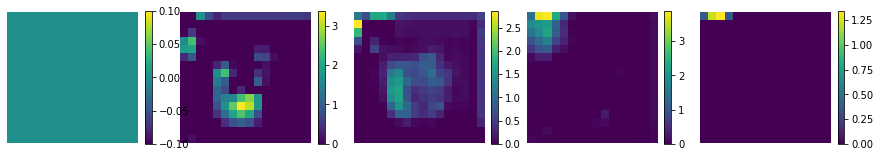

5


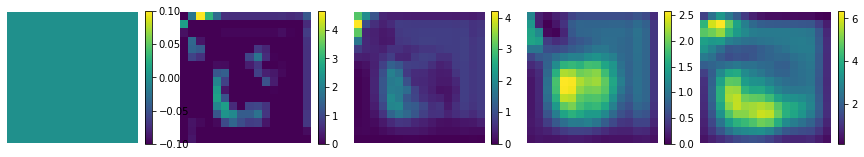

6


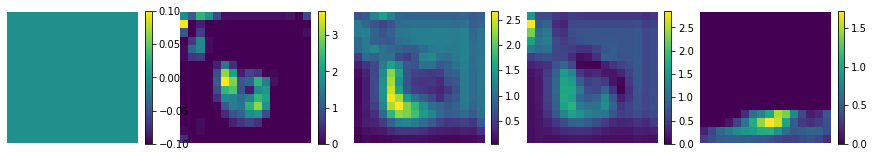

7


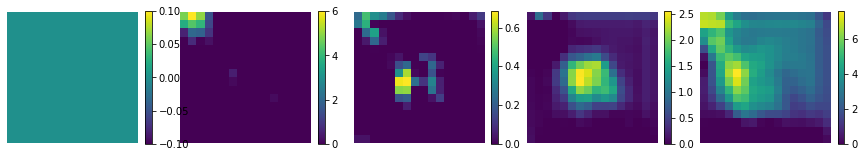

8


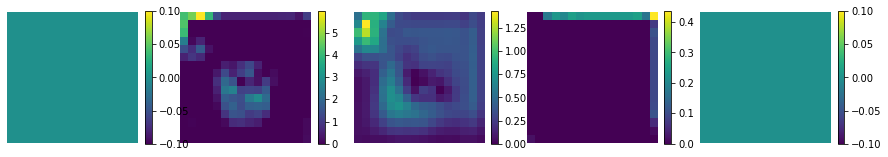

9


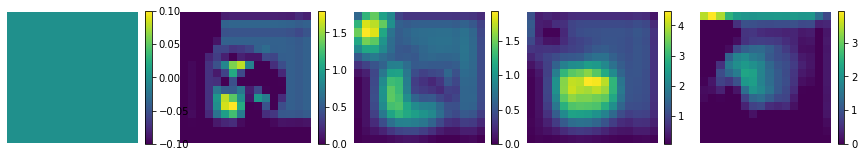

10


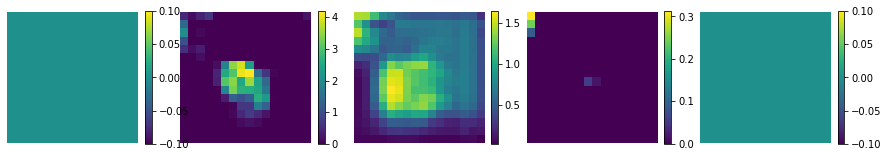

11


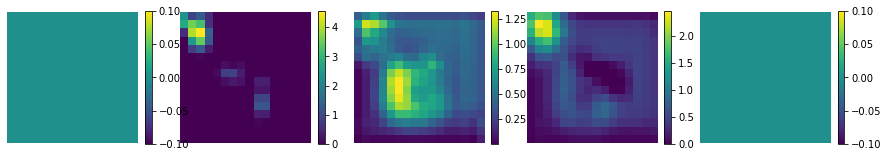

12


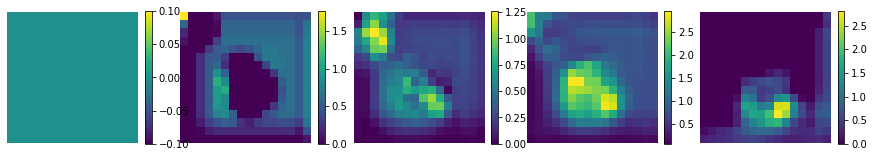

13


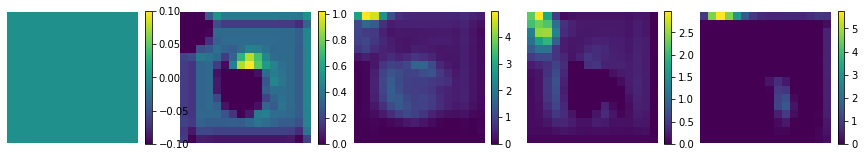

14


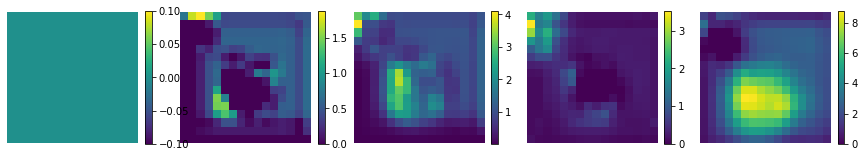

15


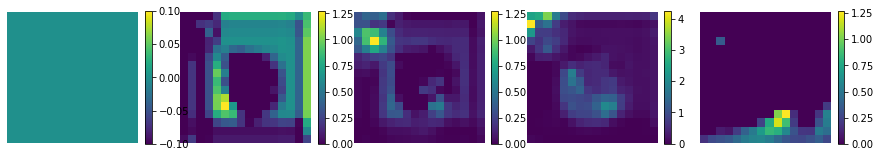

16


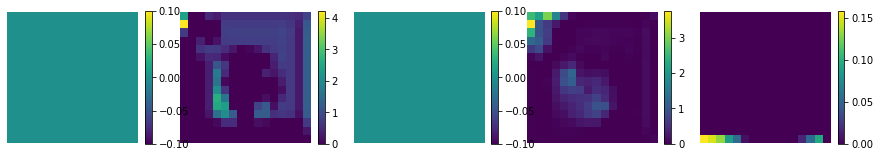

17


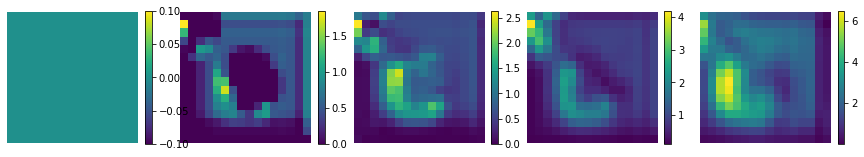

18


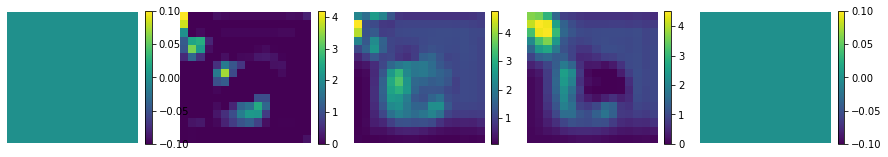

19


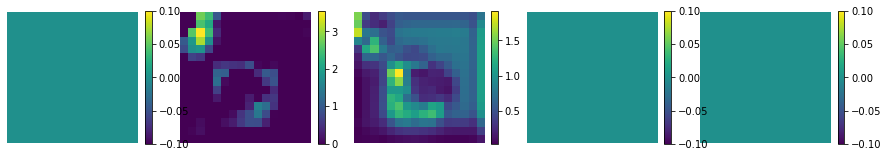

20


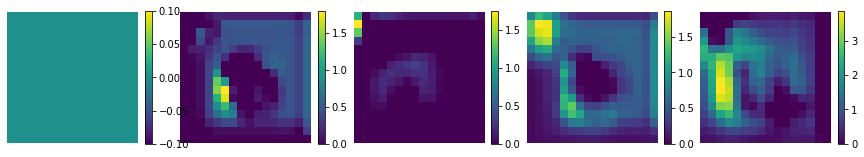

21


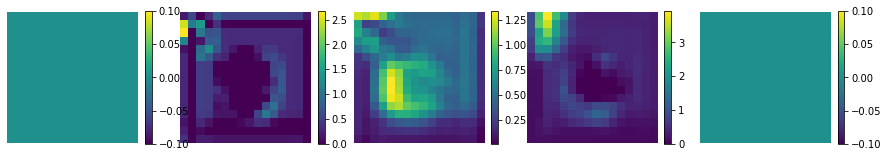

22


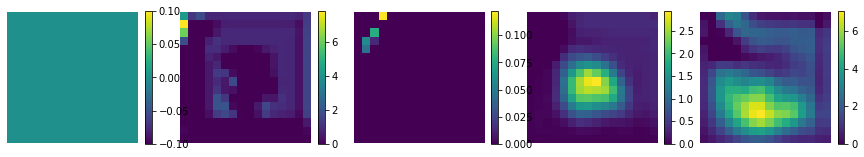

23


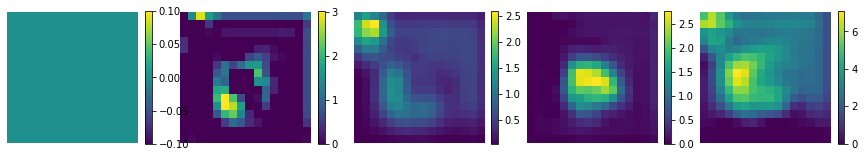

24


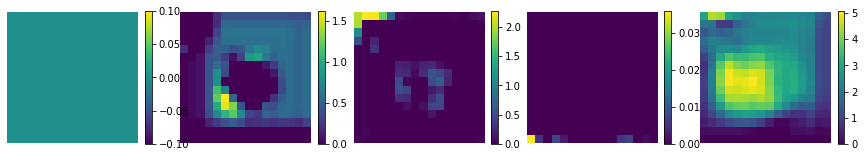

25


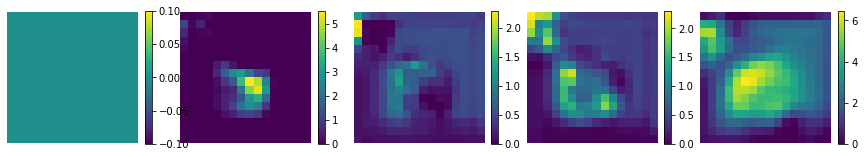

26


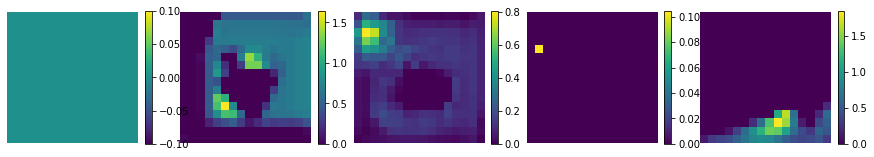

27


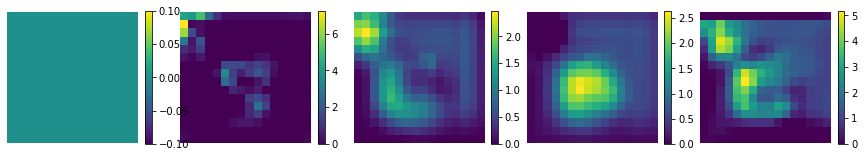

28


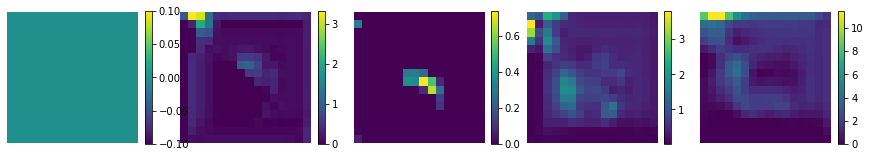

29


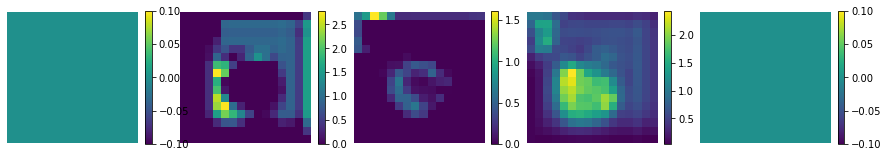

30


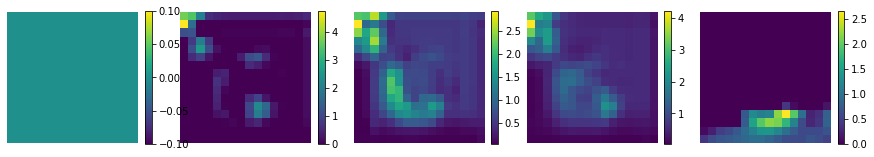

31


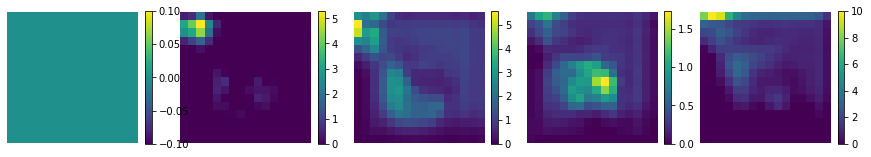

32


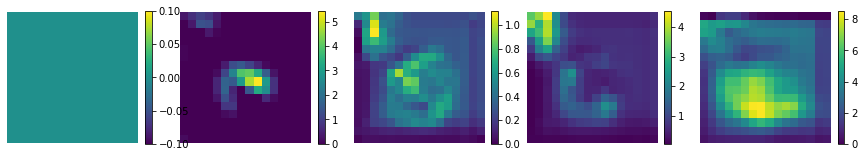

33


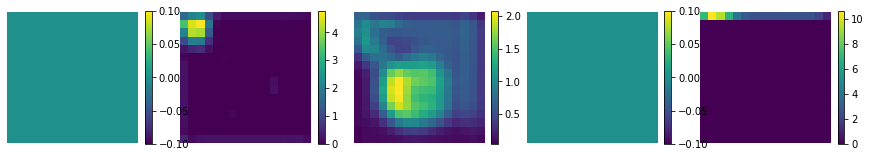

34


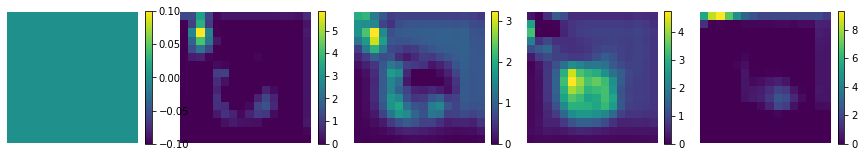

35


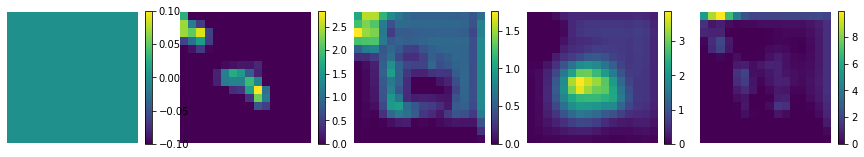

36


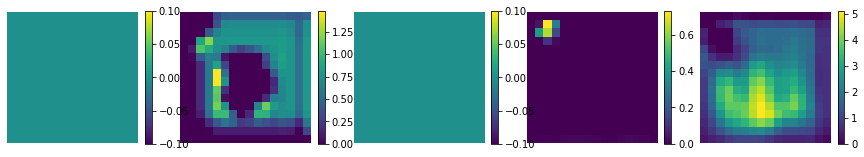

37


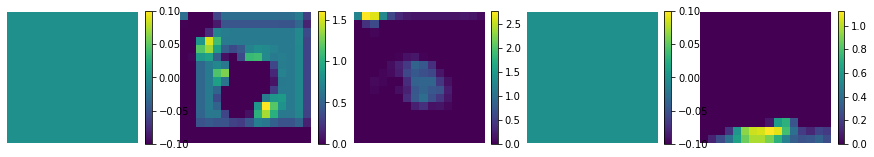

38


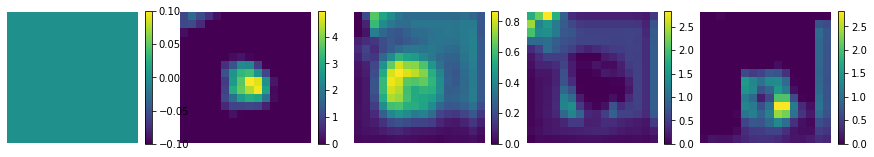

39


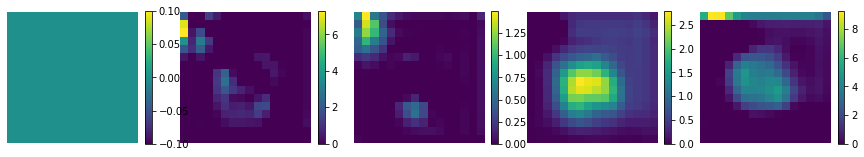

40


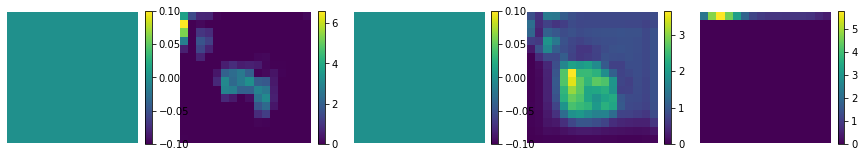

41


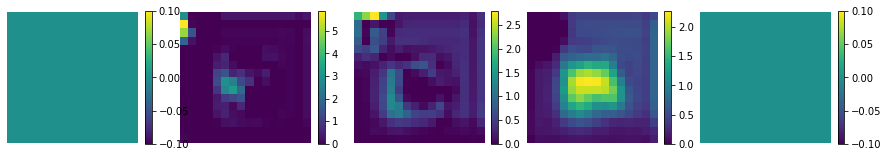

42


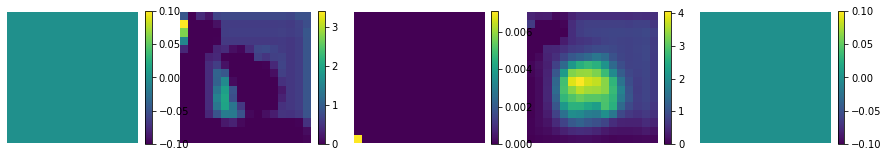

43


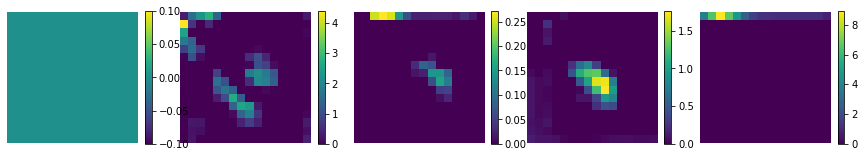

44


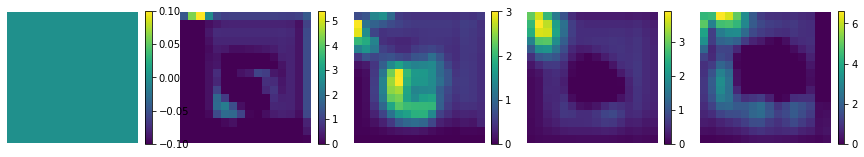

45


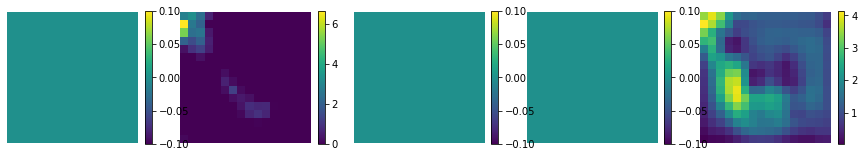

46


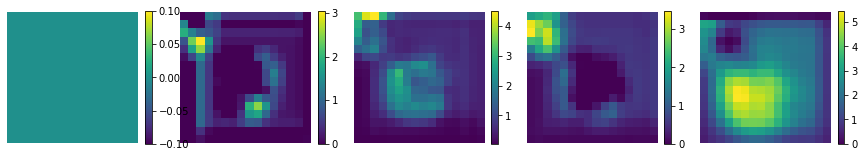

47


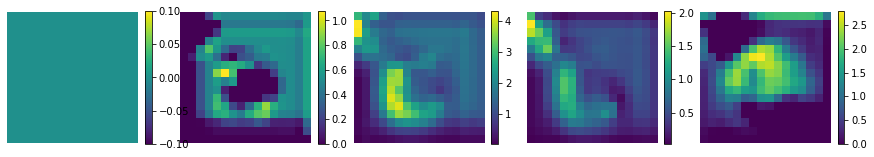

48


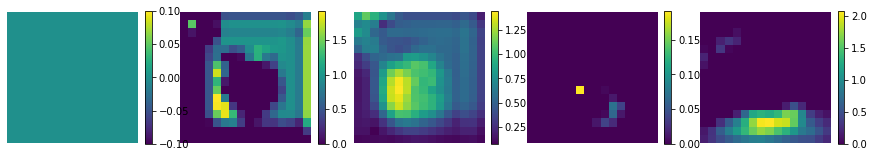

49


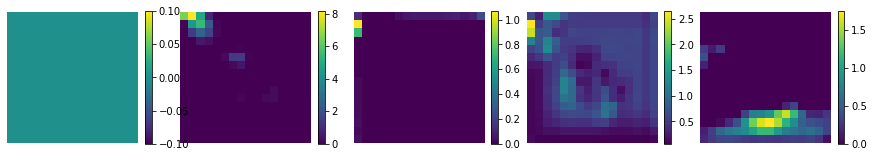

50


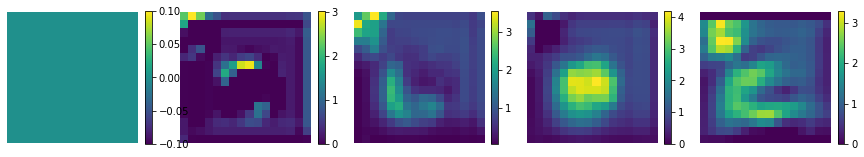

51


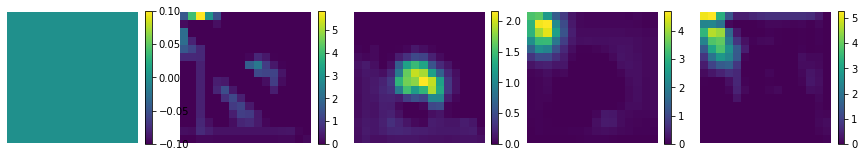

52


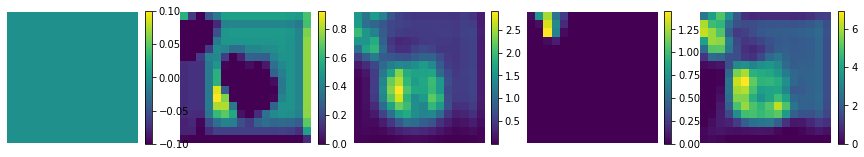

53


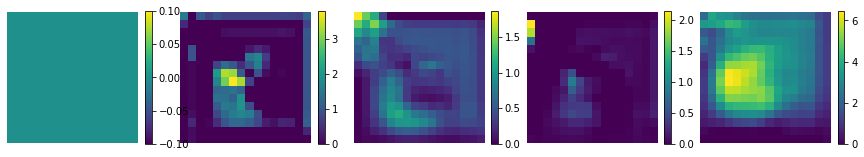

54


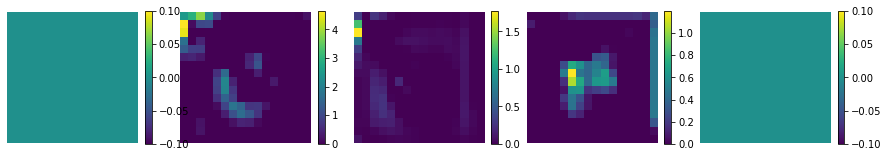

55


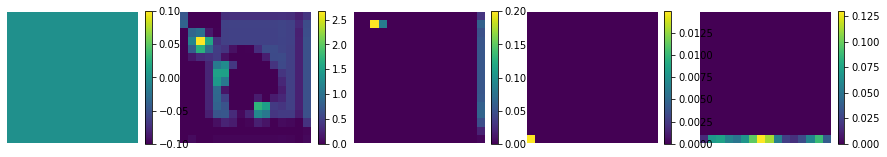

56


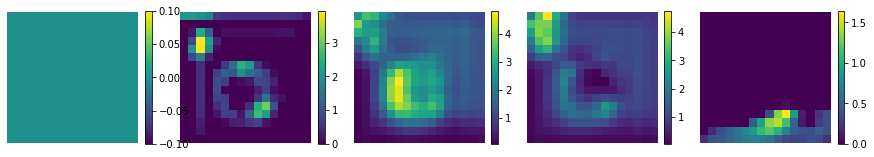

57


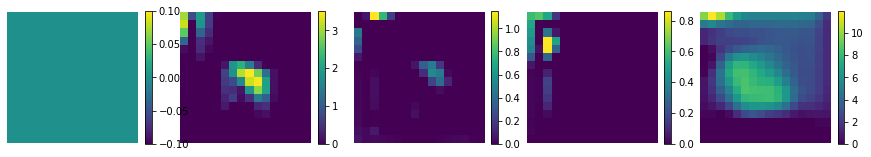

58


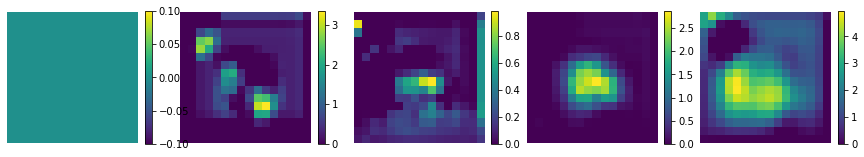

59


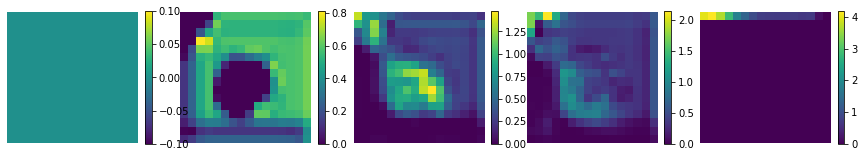

60


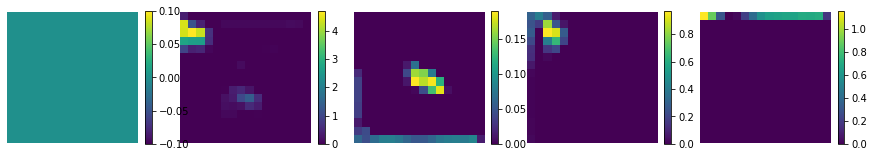

61


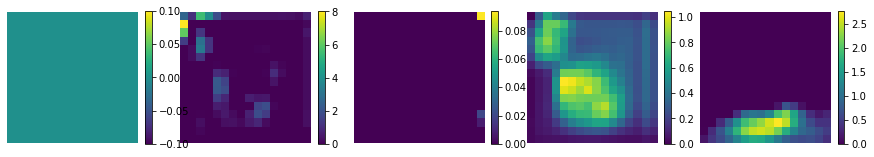

62


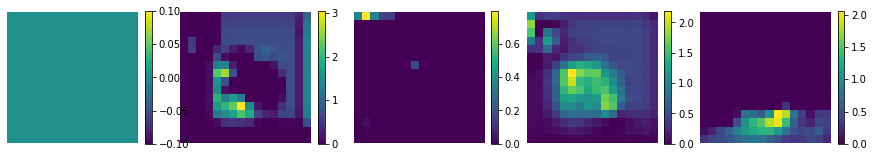

63


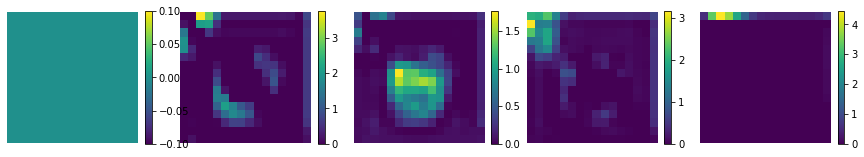

In [23]:
img_, _, pred = evaluate_activations(X=22, R=45, Y=31, pos_x=[5,5], pos_y=[35,35], 
                                     path_vocab_dataset=path_vocab_dataset,
                                     path_model=path_model,
                                     model_file=model_file)

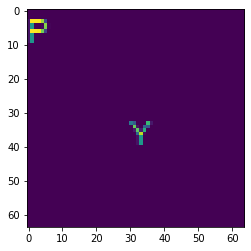

tensor([[1.0000e+00, 3.2091e-07]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [24]:
plt.imshow(img_[1])
plt.show()
pred

For the same image we see the same activation maps by using the function **evaluate_activations** 

This returns also the maps, for which we use the _ variable, and the prediction

using correct initialization
initial alpha 
tensor([[100.,   0.,   0.],
        [  0.,   0., 100.],
        [  0., 100.,   0.]])
initializing with tree.
torch.Size([3, 82112]) torch.Size([1, 64, 16, 16])
0


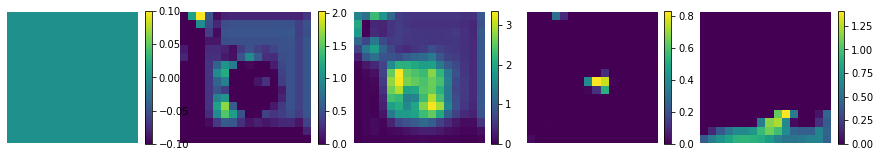

1


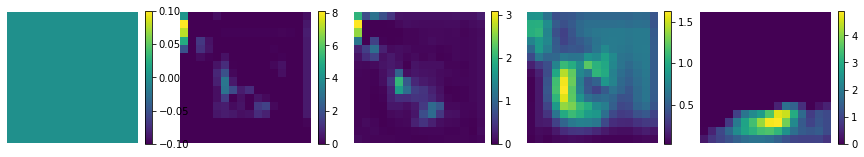

2


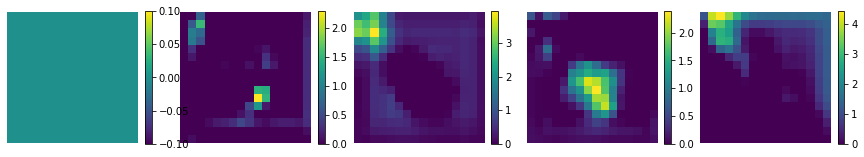

3


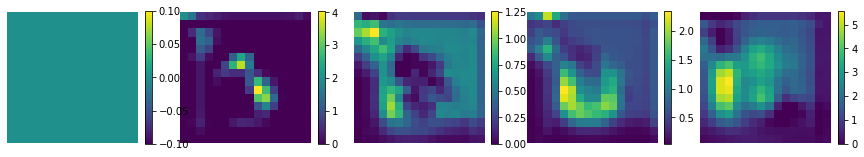

4


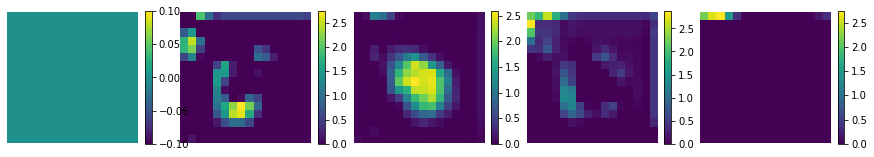

5


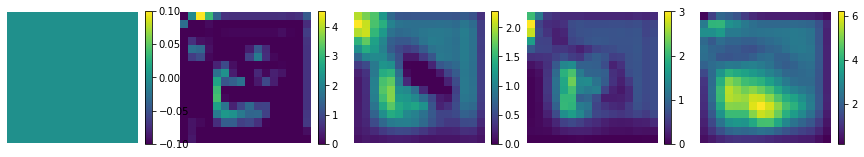

6


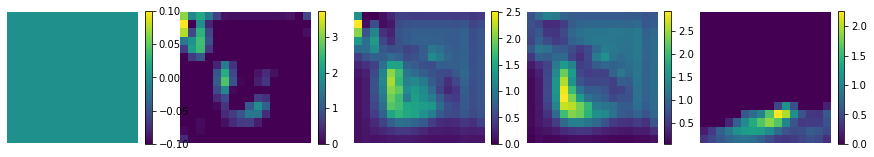

7


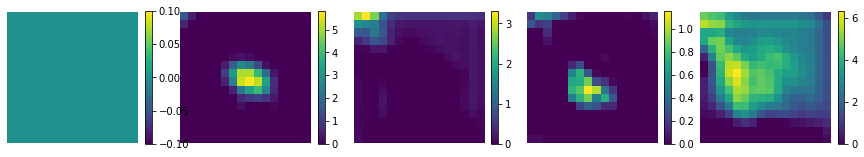

8


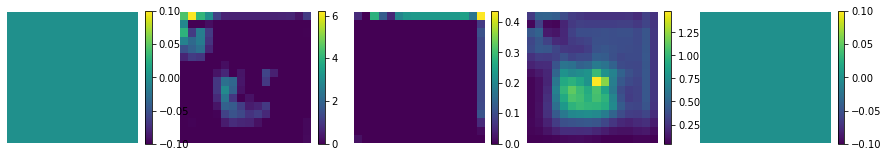

9


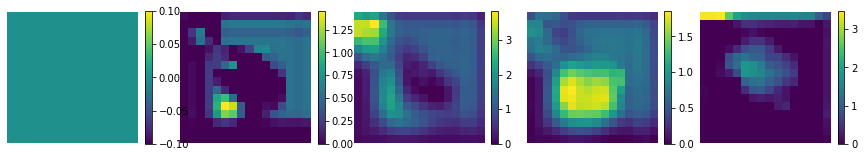

10


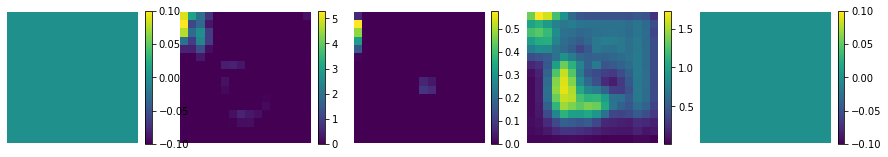

11


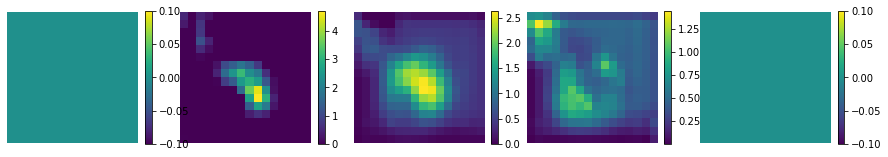

12


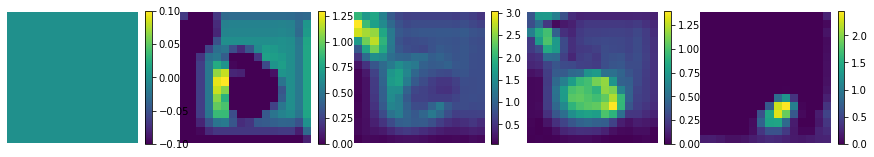

13


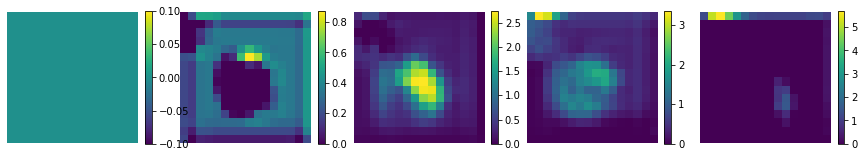

14


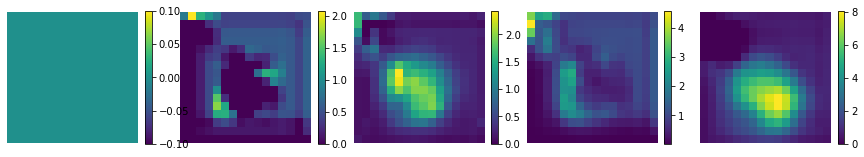

15


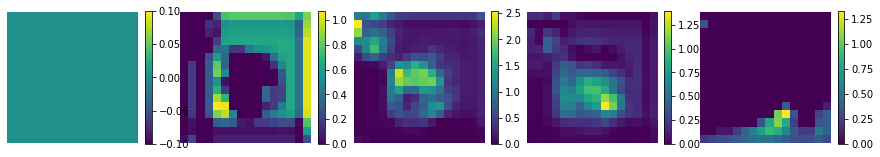

16


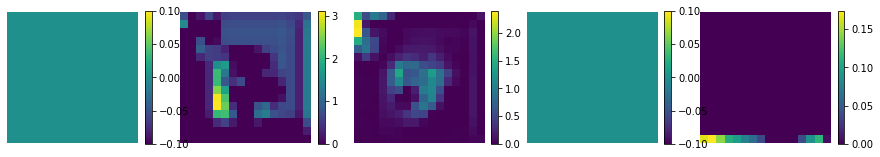

17


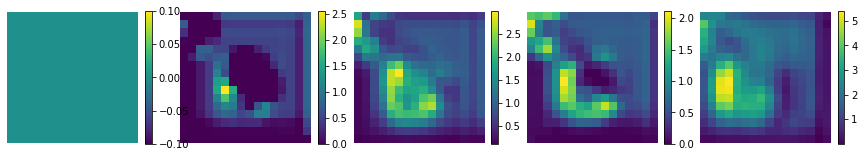

18


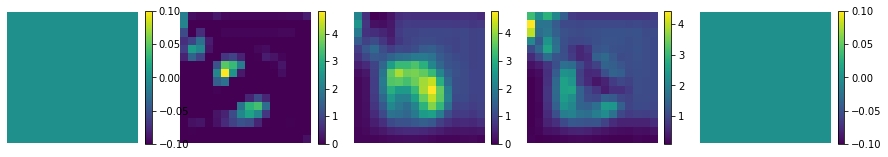

19


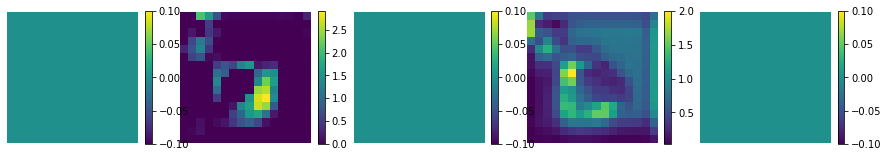

20


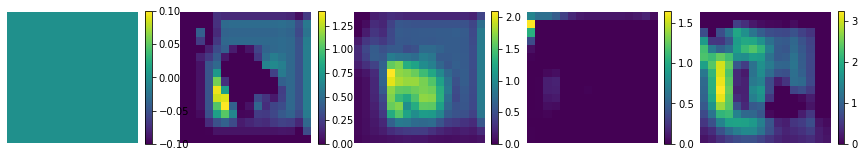

21


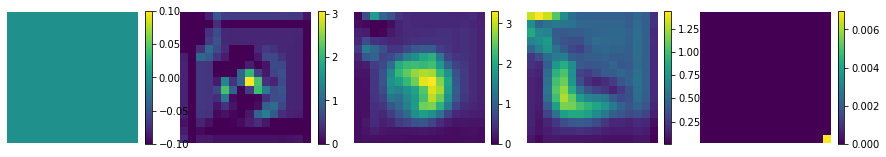

22


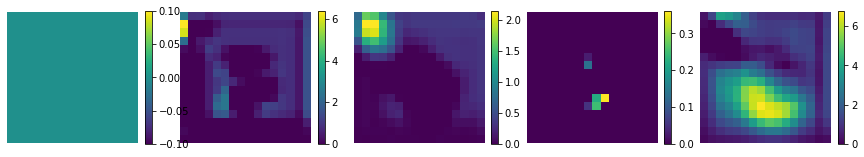

23


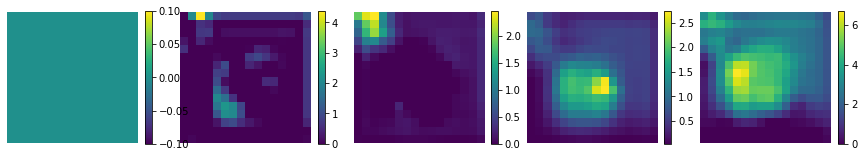

24


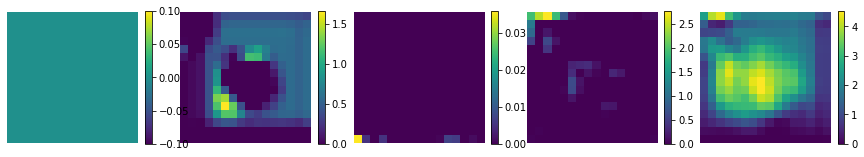

25


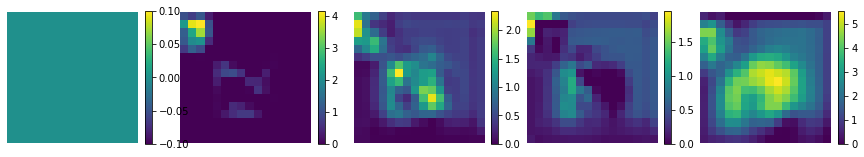

26


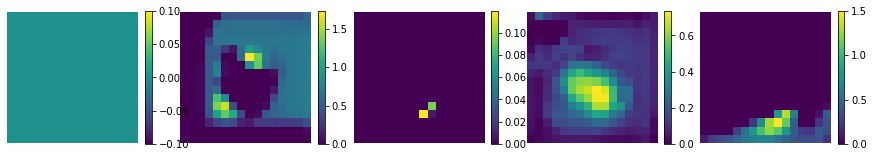

27


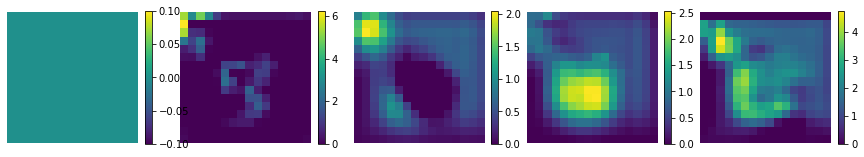

28


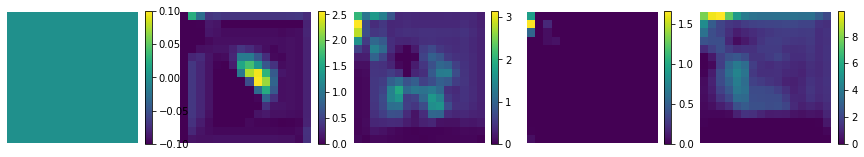

29


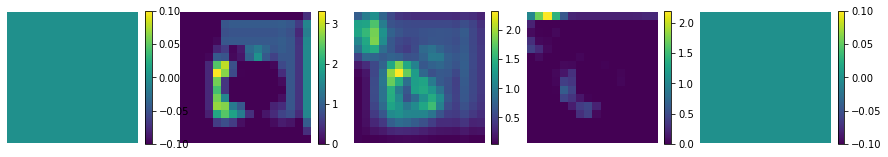

30


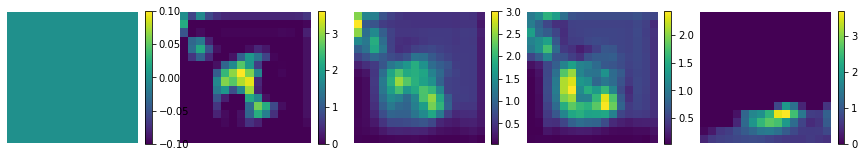

31


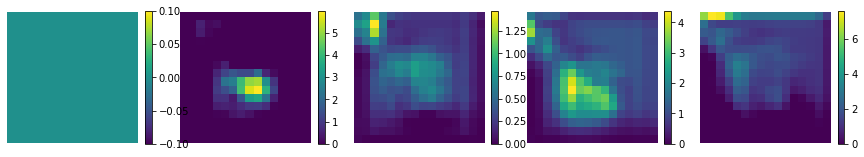

32


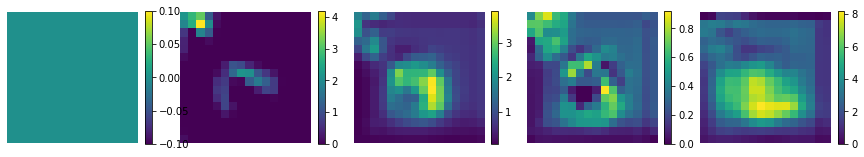

33


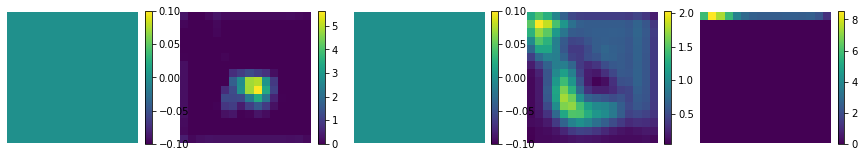

34


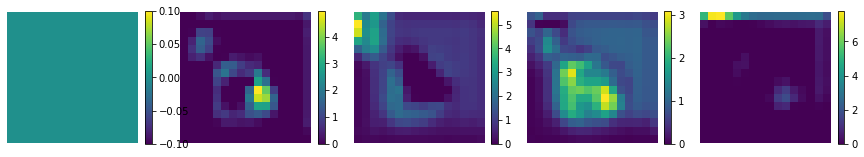

35


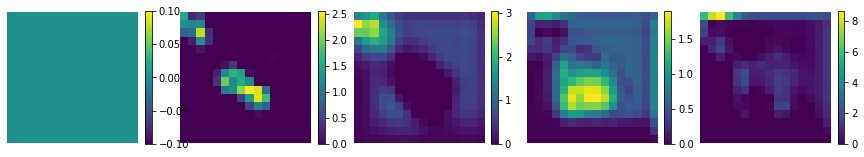

36


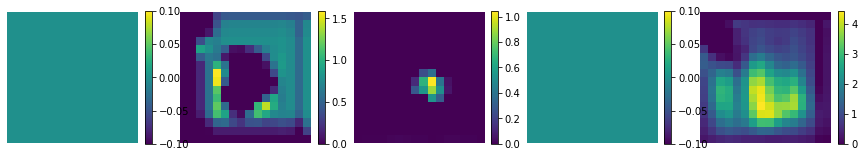

37


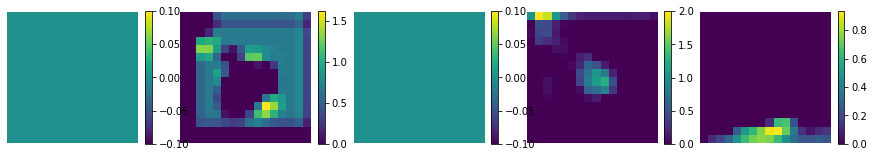

38


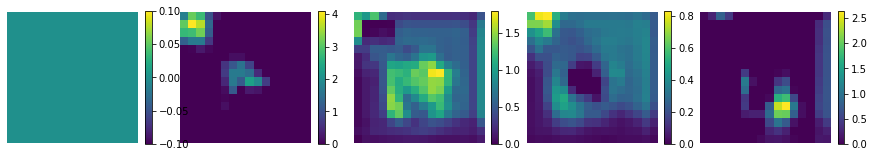

39


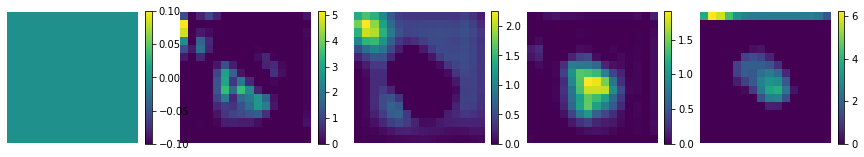

40


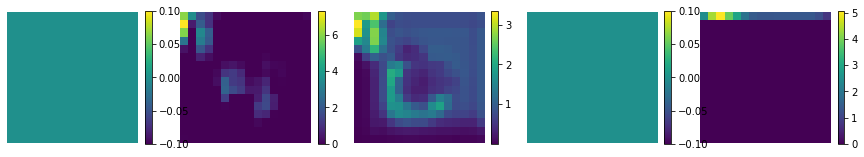

41


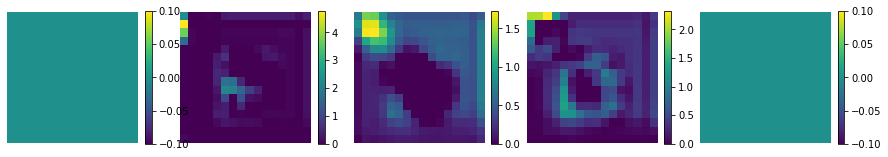

42


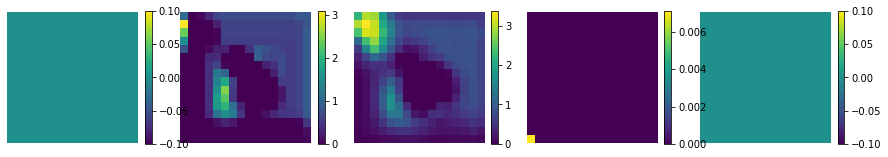

43


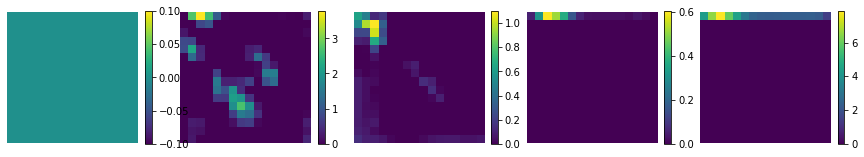

44


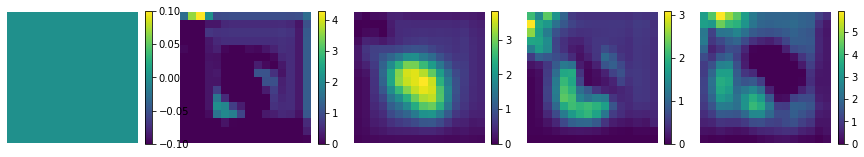

45


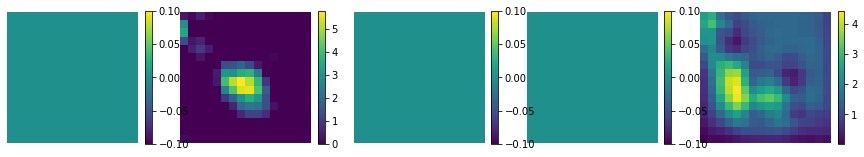

46


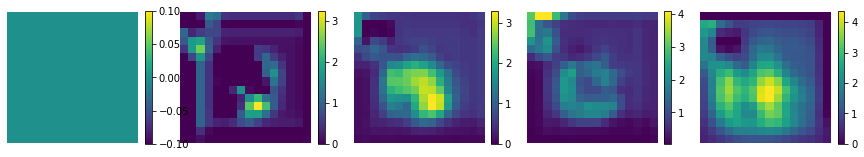

47


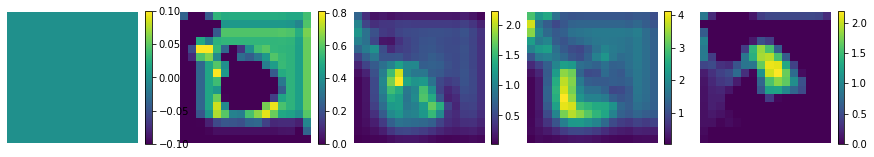

48


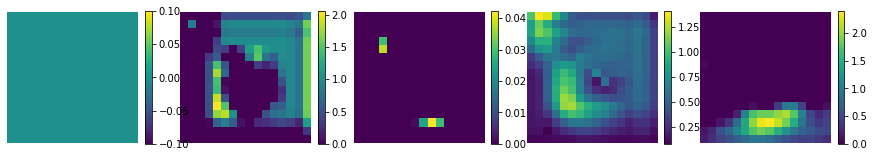

49


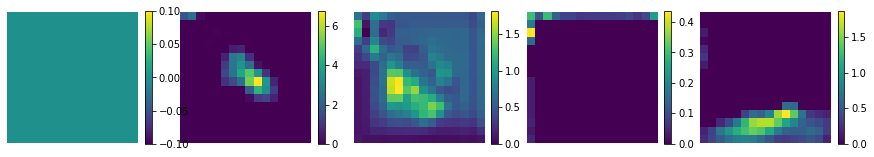

50


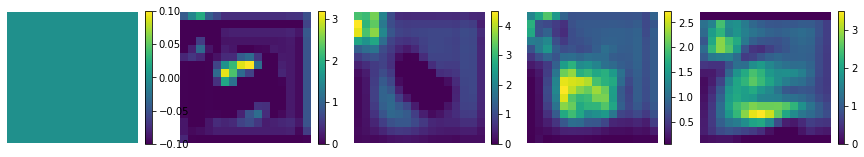

51


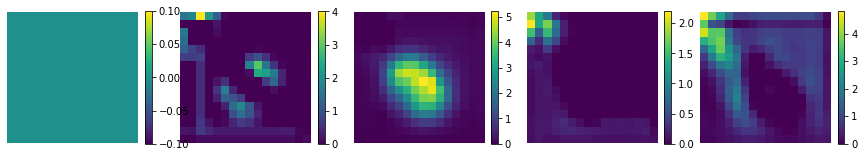

52


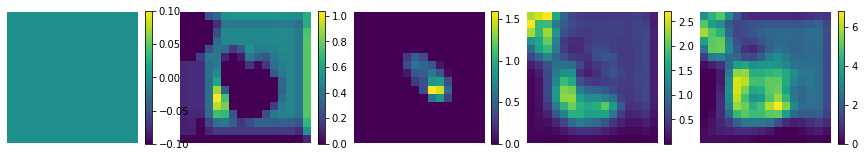

53


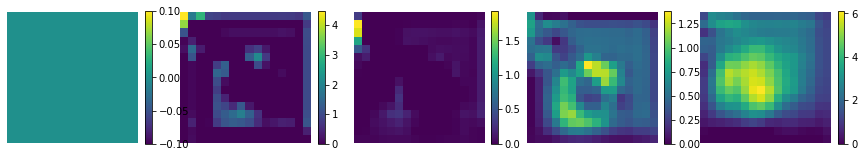

54


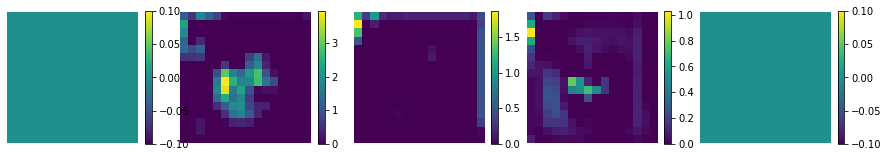

55


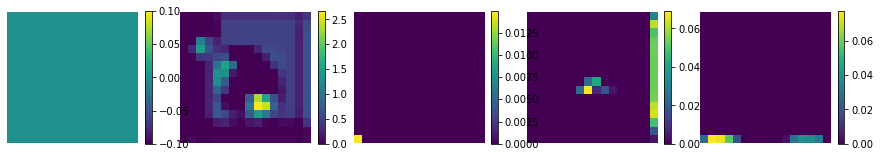

56


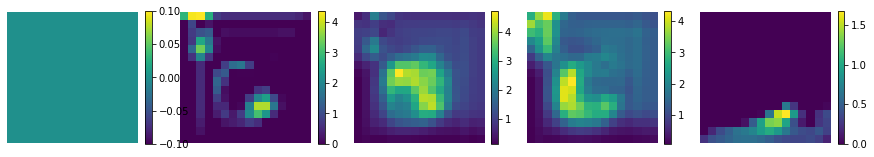

57


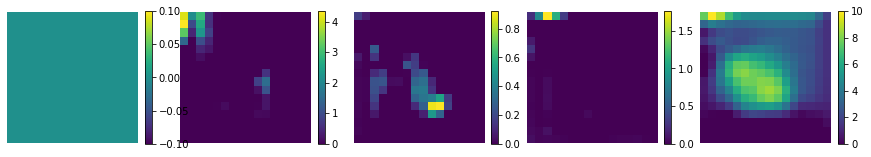

58


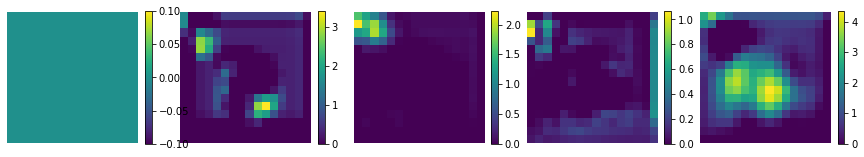

59


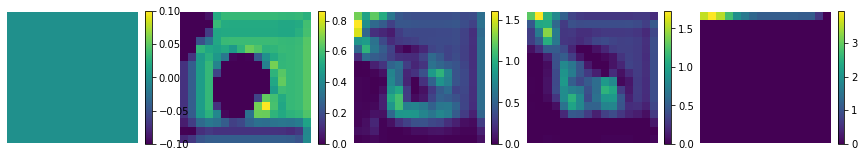

60


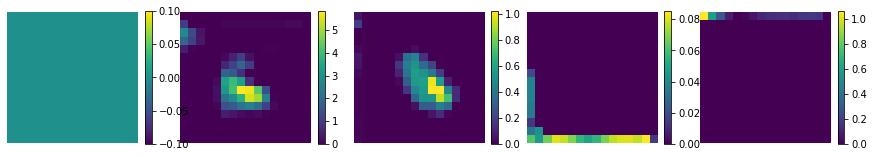

61


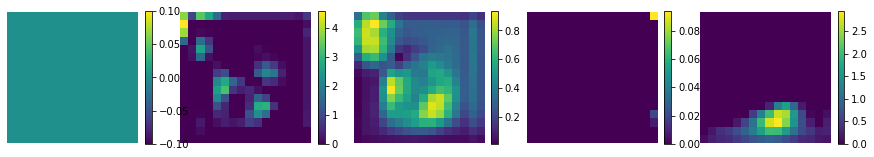

62


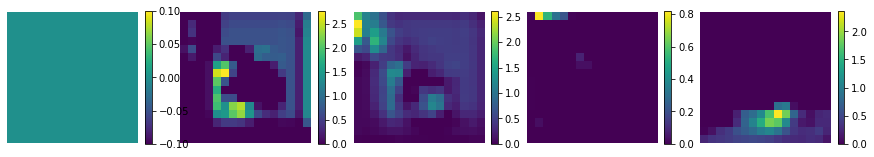

63


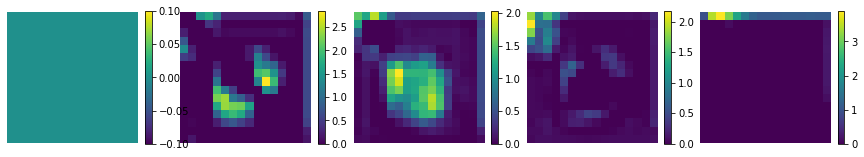

In [25]:
img_, _, pred = evaluate_activations(X=31, R=45, Y=22, pos_x=[5,5], pos_y=[35,35], 
                                     path_vocab_dataset=path_vocab_dataset,
                                     path_model=path_model,
                                     model_file=lst_slurm_id_tree[0] + '.pt.best')

In [26]:
pred

tensor([[1.0000e+00, 7.2474e-07]], device='cuda:0', grad_fn=<SoftmaxBackward>)

### Let's see if we get something more interpretable for the model trained on 5 objects

In [27]:
key = 5

path_vocab_dataset = join(data_path[key], 'vocab.json')
vocab_dataset = load_vocab(path_vocab_dataset)
path_model = results_path[key]

lst_best_models = [f_ for f_ in os.listdir(results_path[key]) if f_.endswith('pt.best')]

../vr/models/shnmn.py:248: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  alpha = INITS[alpha_init](torch.Tensor(num_modules, num_question_tokens))


initial alpha 
tensor([[0.7135, 0.3774, 0.0437],
        [0.9659, 0.4280, 0.5989],
        [0.1279, 0.7391, 0.6439]])
initializing with tree.
torch.Size([3, 64]) torch.Size([1, 64, 16, 16])
0


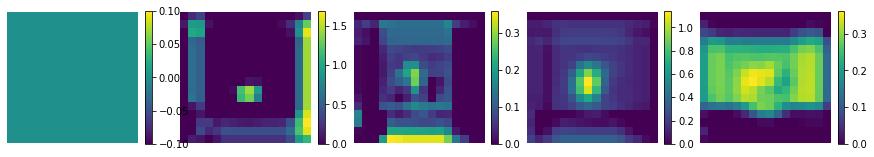

1


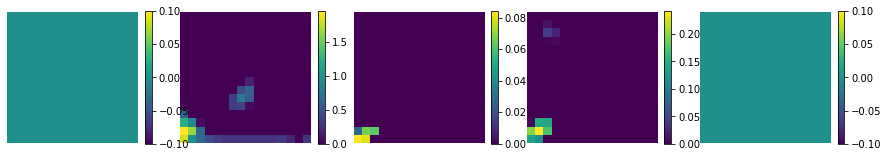

2


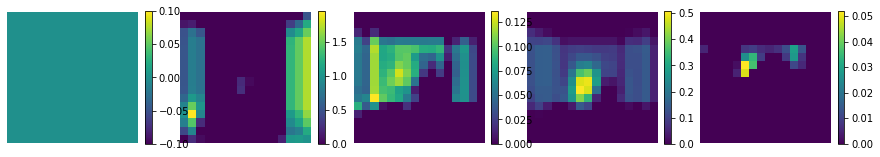

3


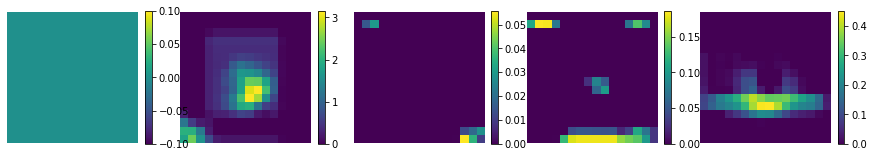

4


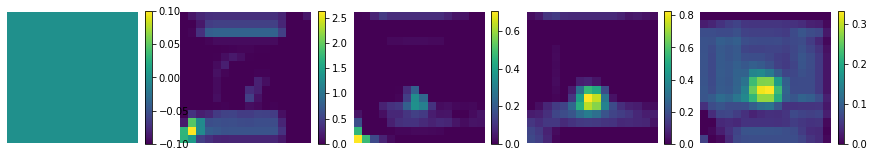

5


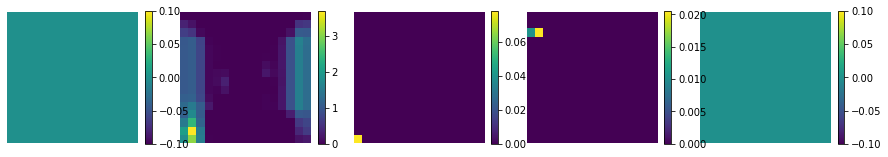

6


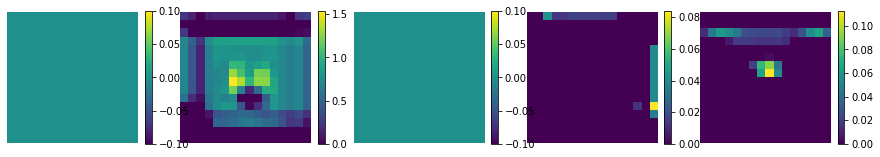

7


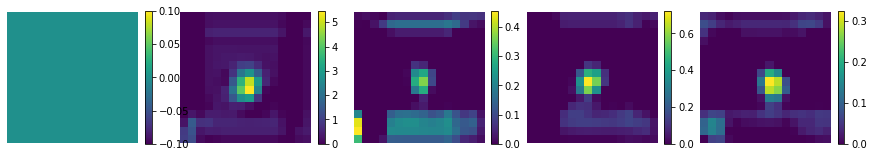

8


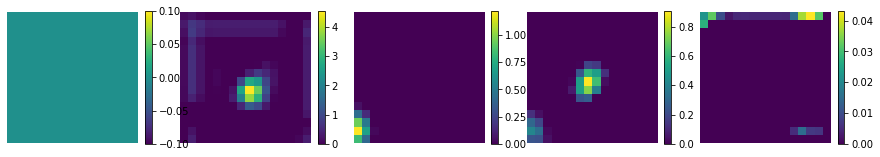

9


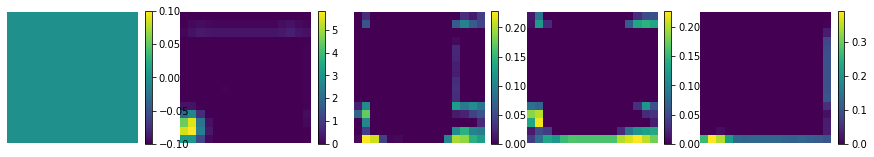

10


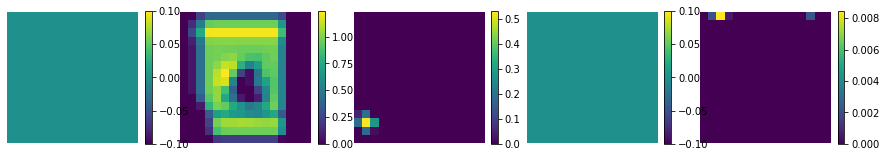

11


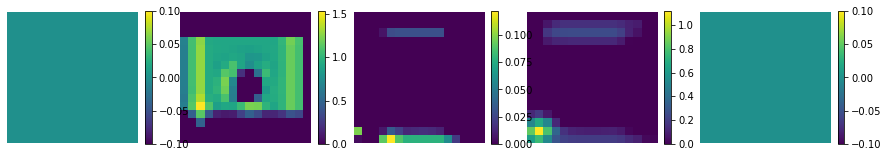

12


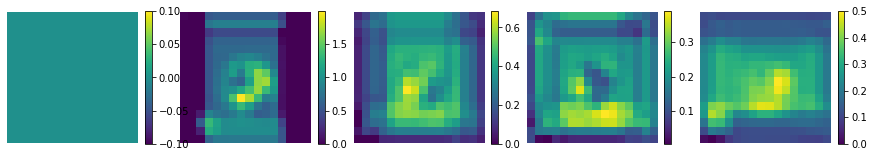

13


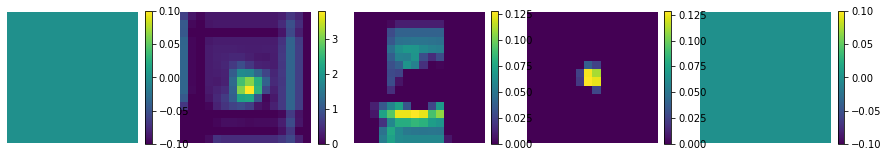

14


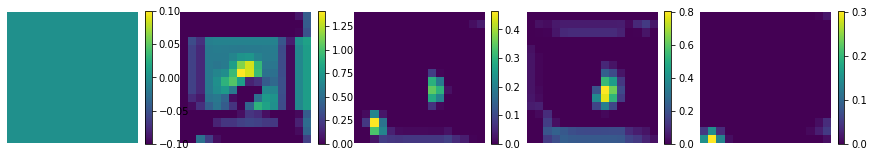

15


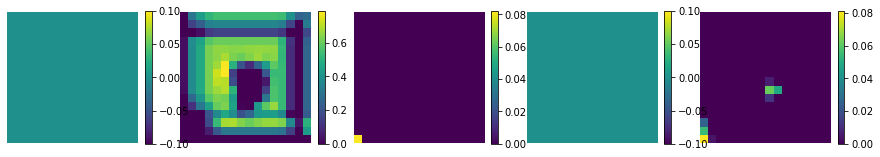

16


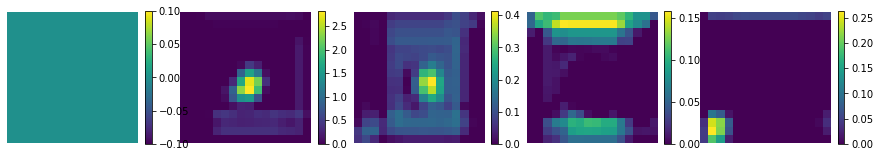

17


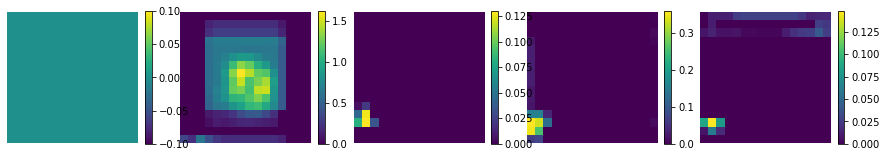

18


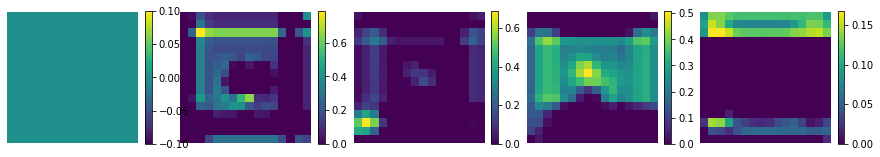

19


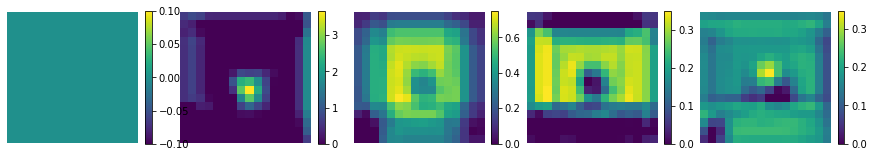

20


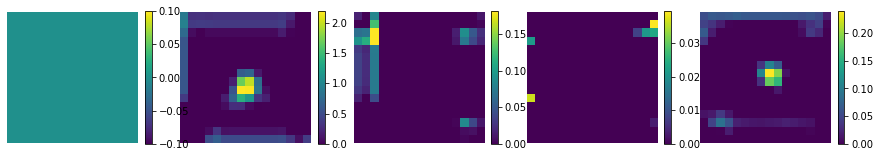

21


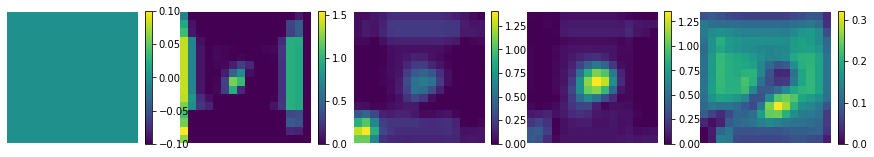

22


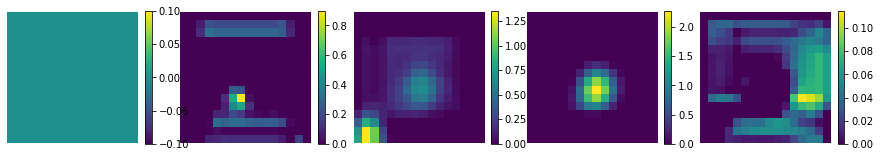

23


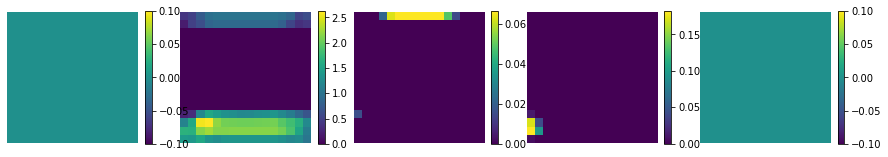

24


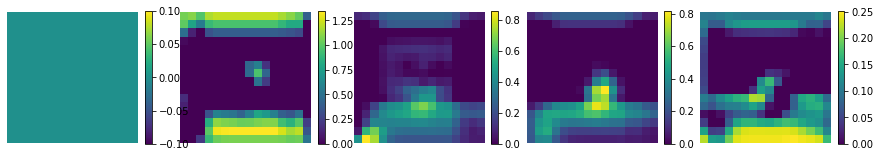

25


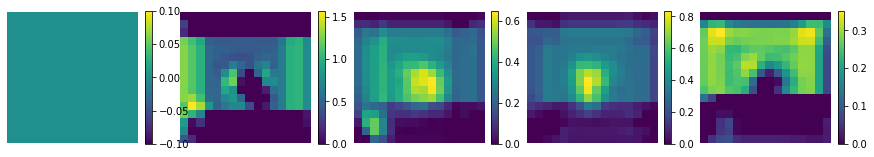

26


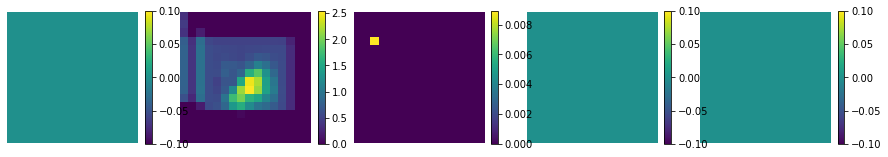

27


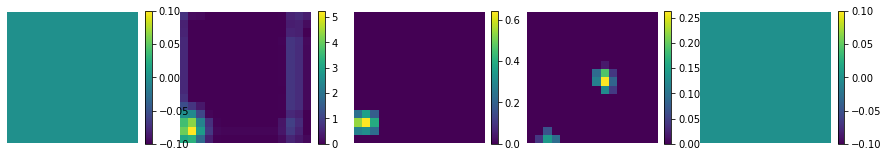

28


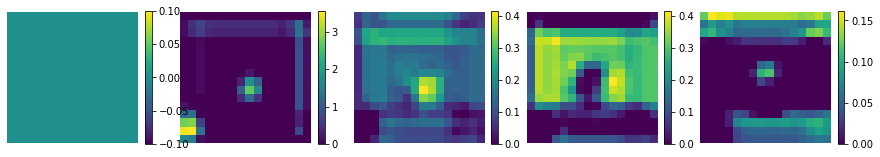

29


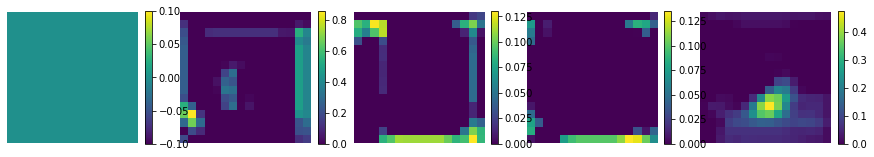

30


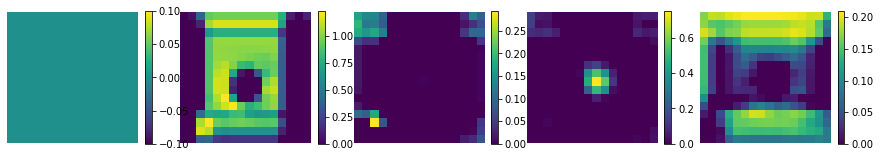

31


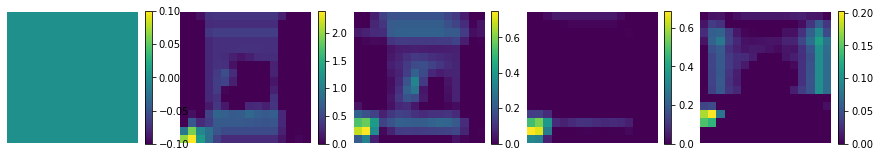

32


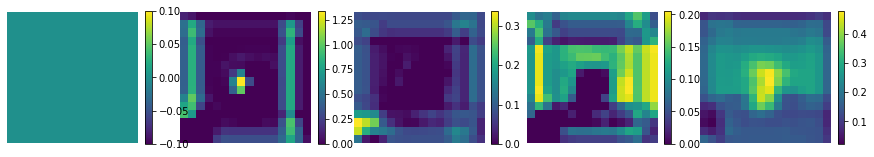

33


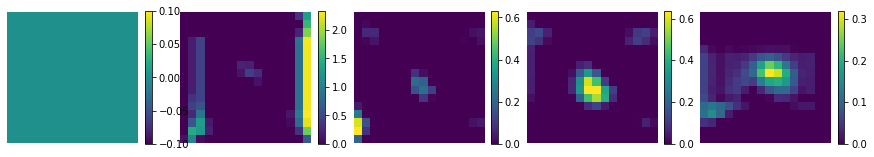

34


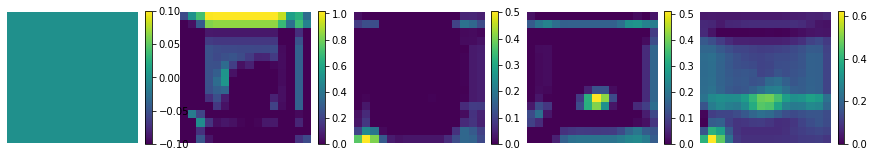

35


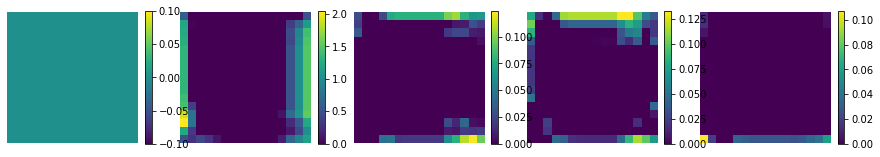

36


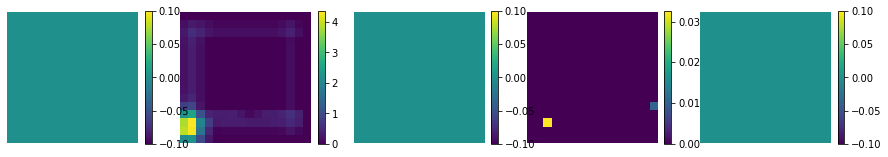

37


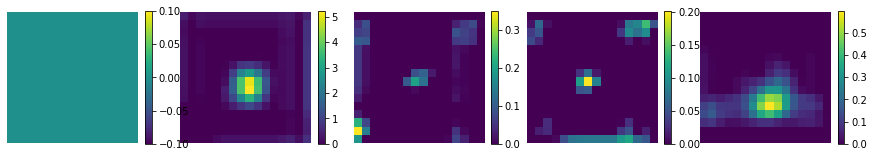

38


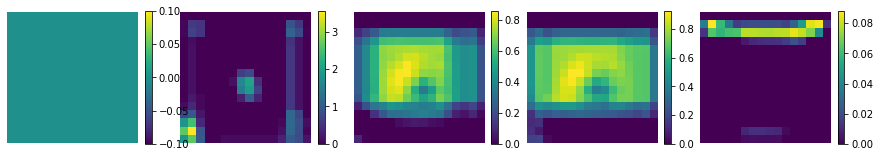

39


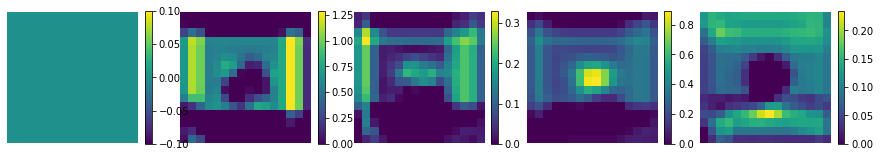

40


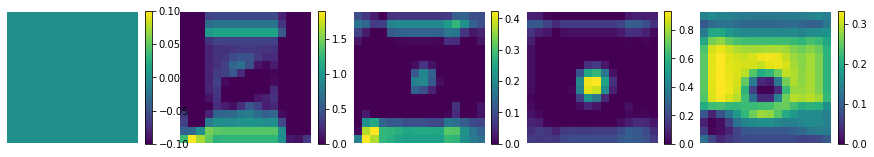

41


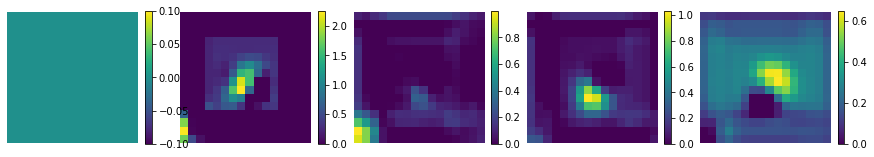

42


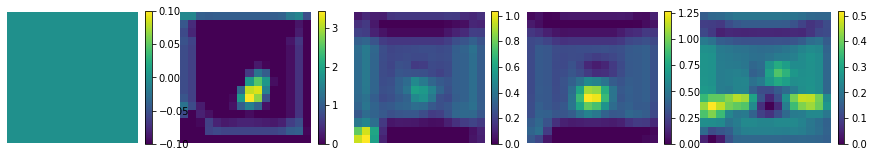

43


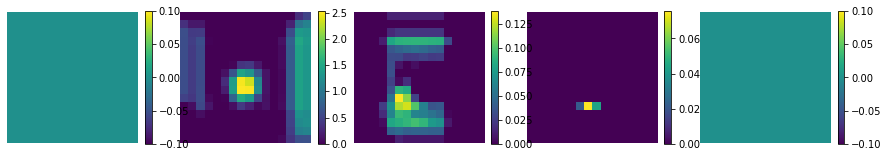

44


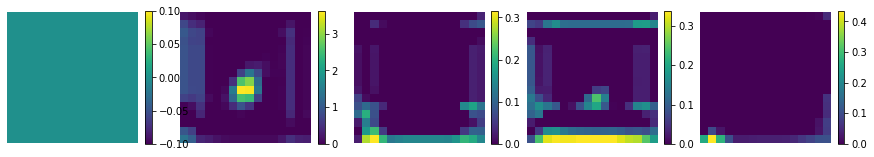

45


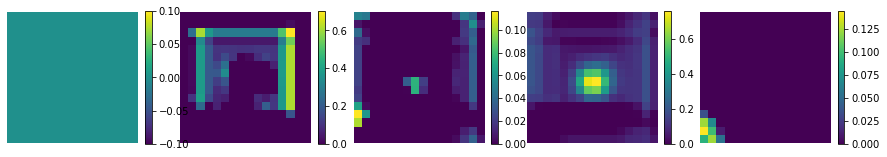

46


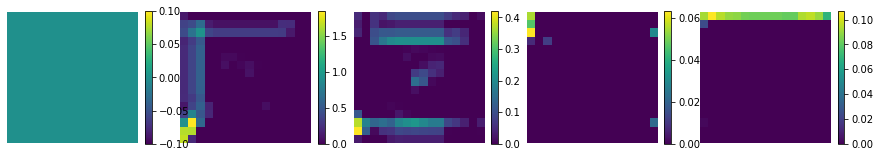

47


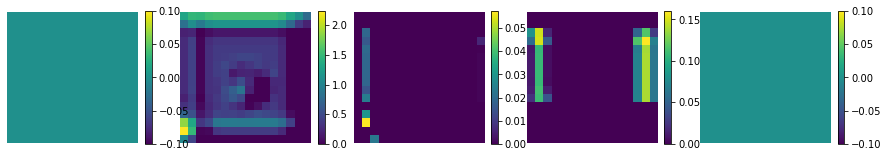

48


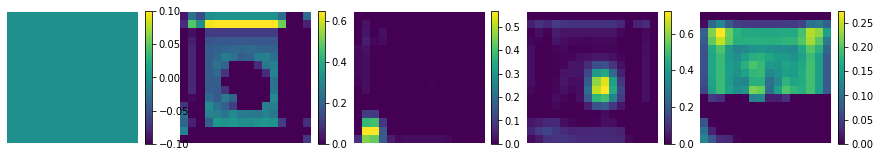

49


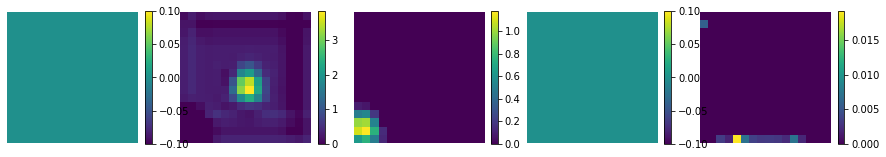

50


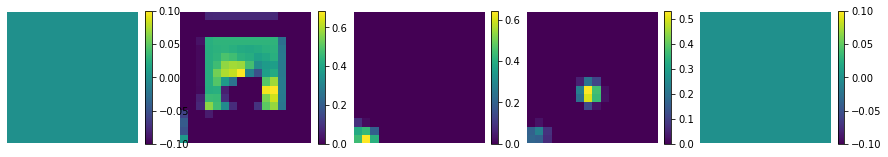

51


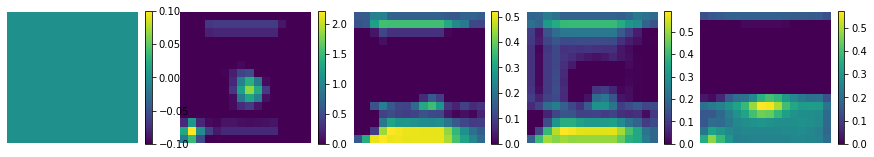

52


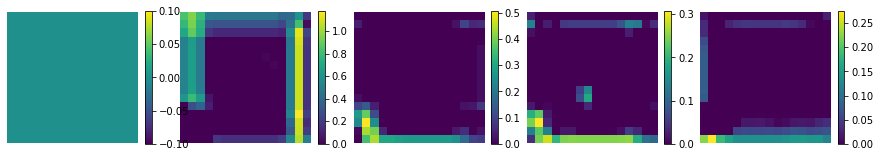

53


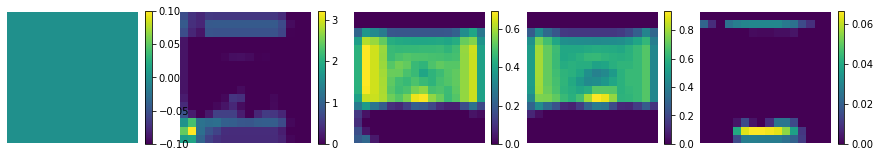

54


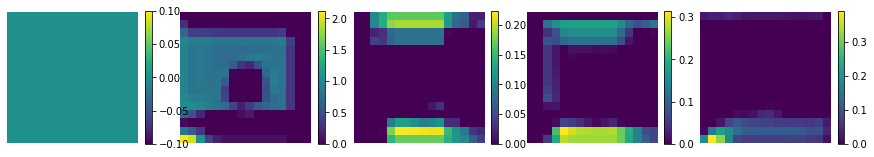

55


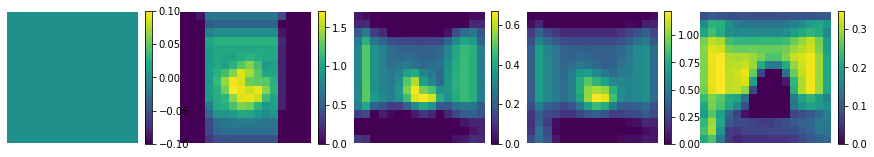

56


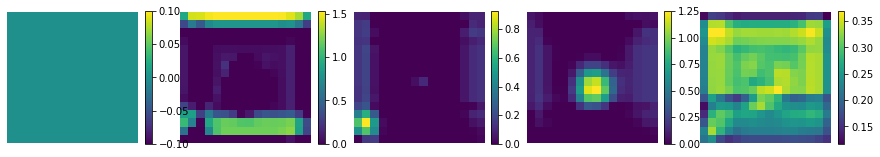

57


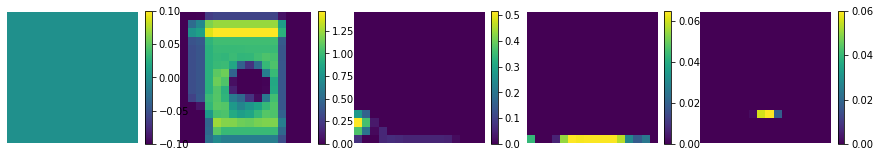

58


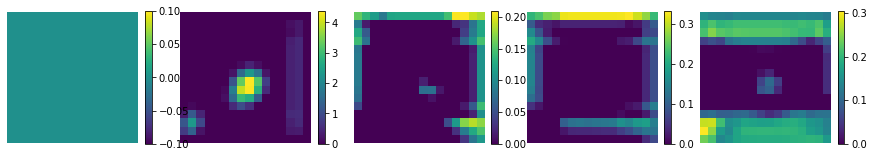

59


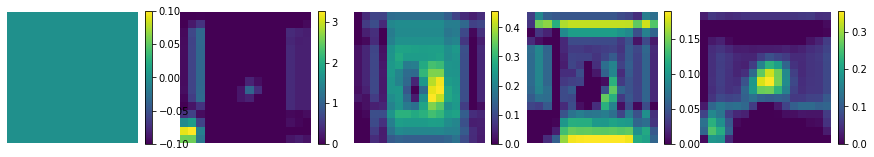

60


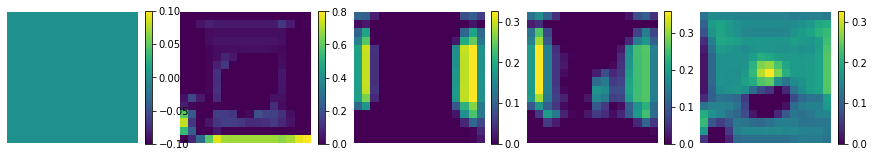

61


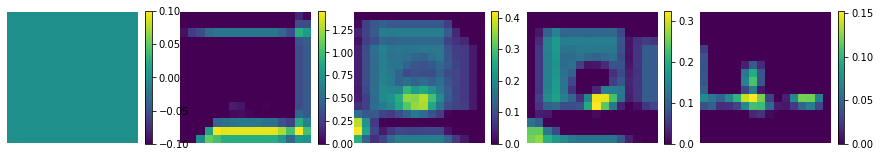

62


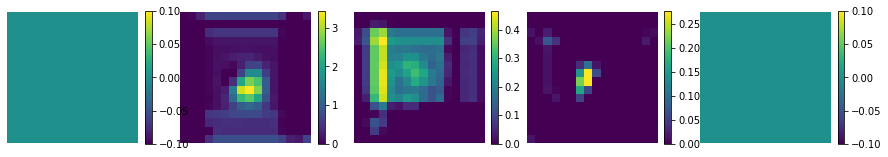

63


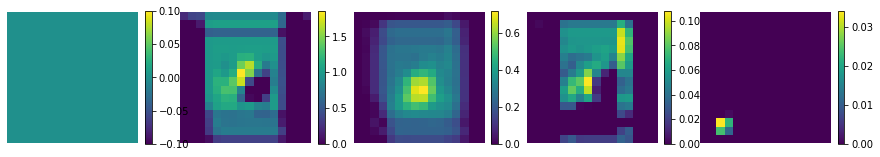

In [28]:
img_, _, pred = evaluate_activations(X=22, R=45, Y=31, pos_x=[5,55], pos_y=[35,35], 
                                     path_vocab_dataset=path_vocab_dataset,
                                     path_model=path_model,
                                     model_file=lst_best_models[0])

initial alpha 
tensor([[0.7737, 0.2396, 0.8568],
        [0.3705, 0.1823, 0.7401],
        [0.8024, 0.5611, 0.8675]])
initializing with tree.
torch.Size([3, 64]) torch.Size([1, 64, 16, 16])
0


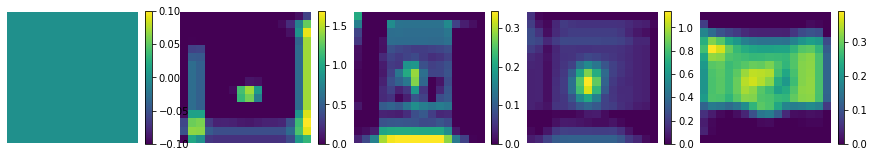

1


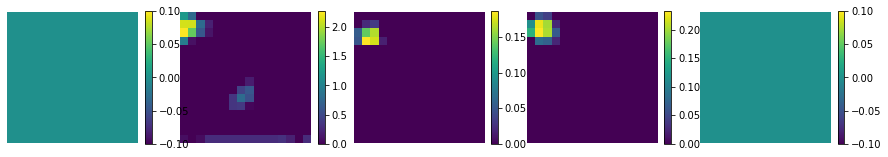

2


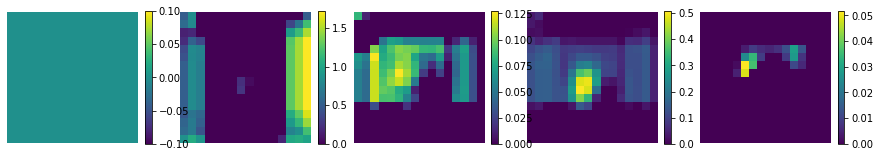

3


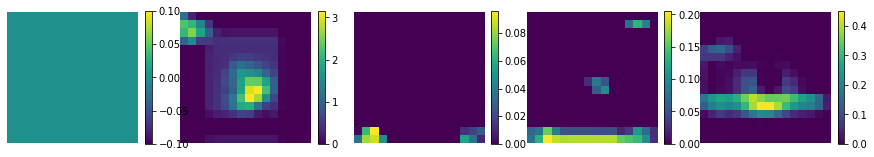

4


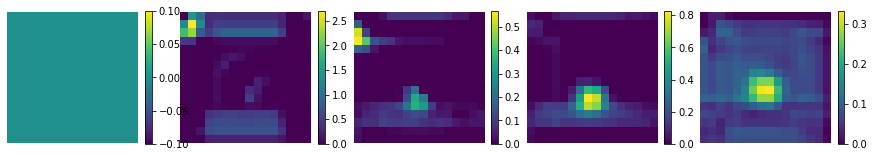

5


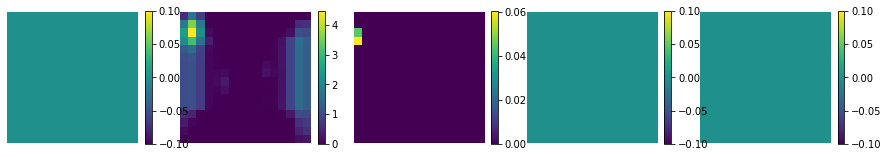

6


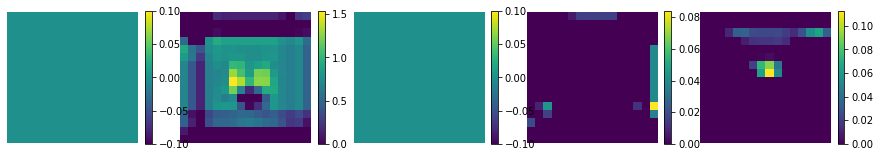

7


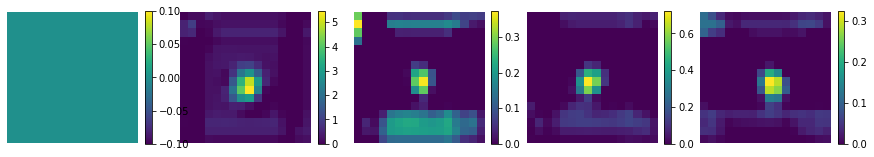

8


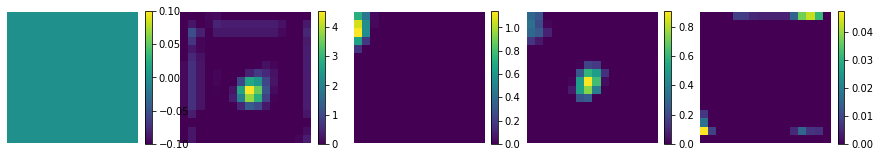

9


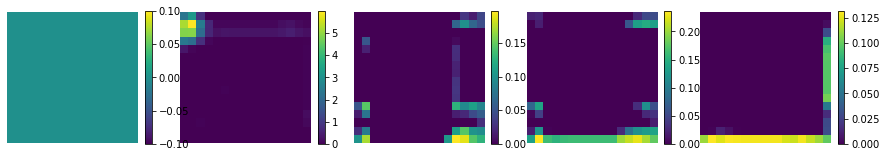

10


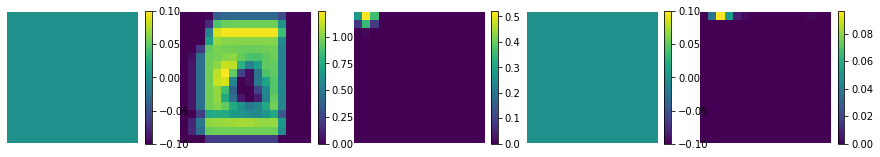

11


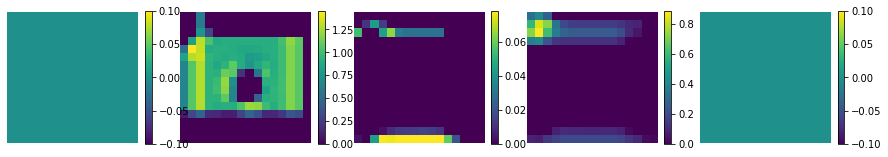

12


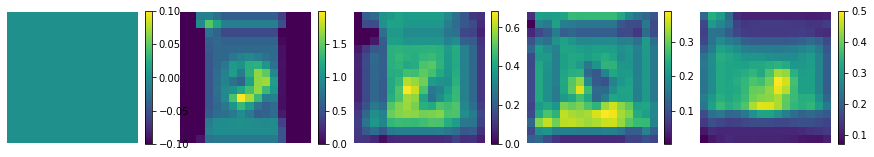

13


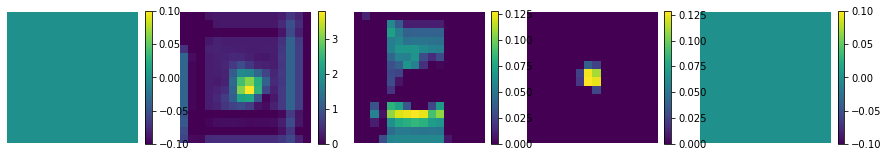

14


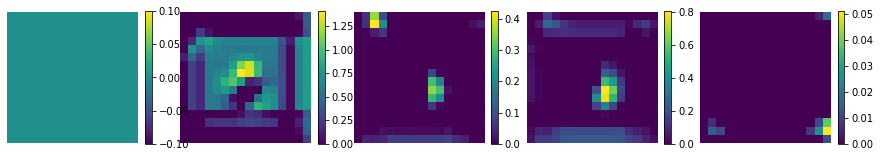

15


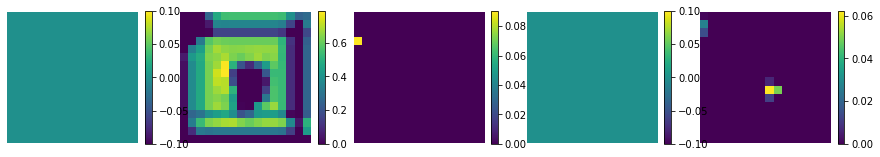

16


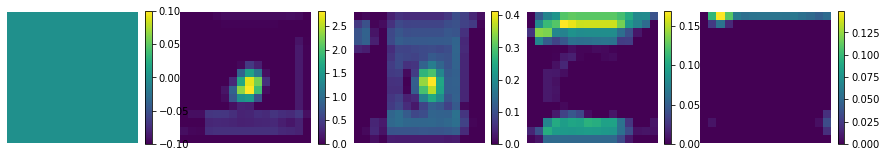

17


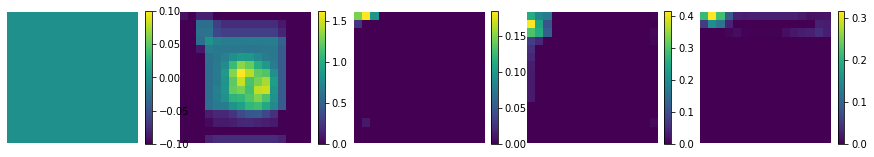

18


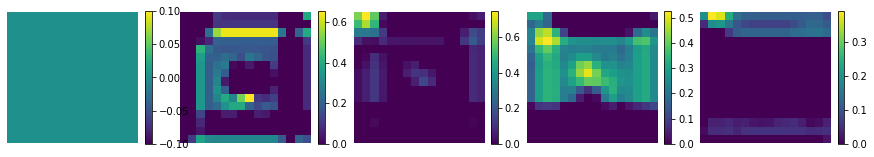

19


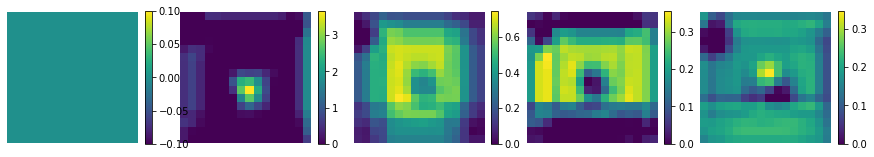

20


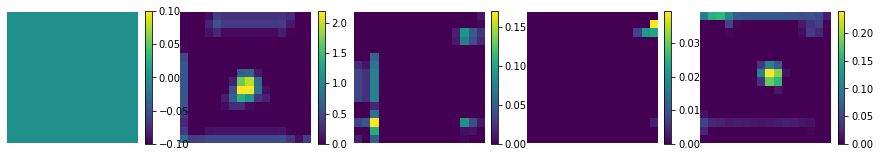

21


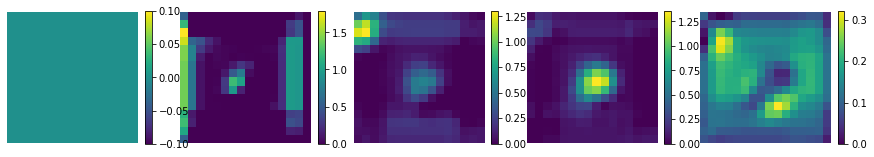

22


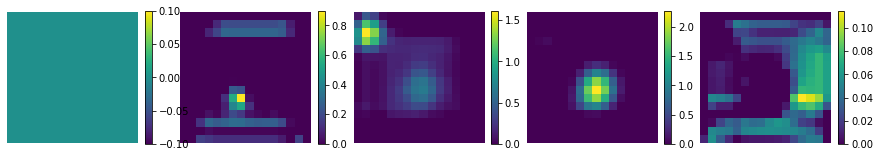

23


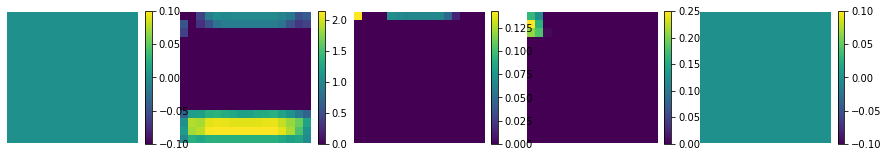

24


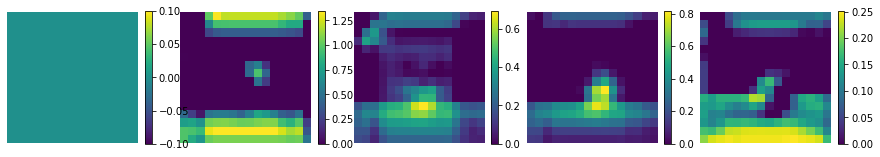

25


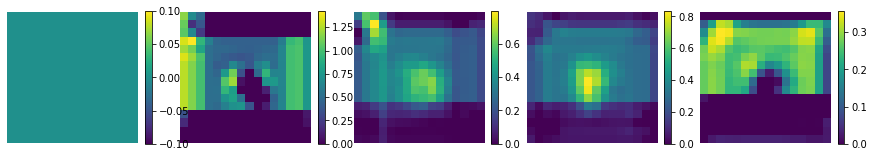

26


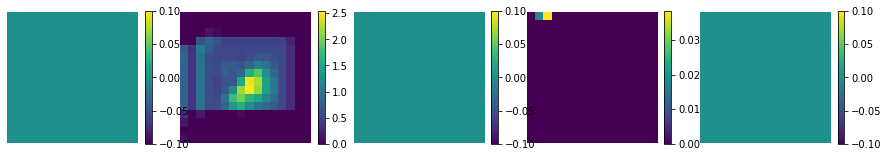

27


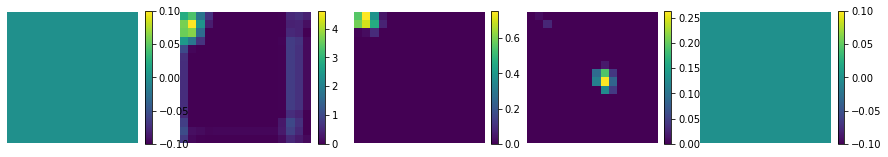

28


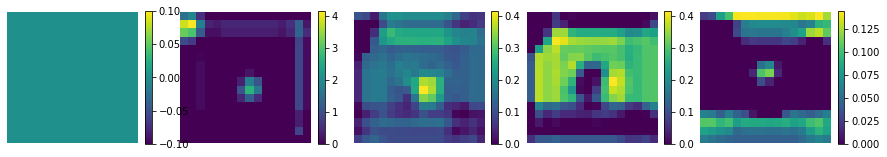

29


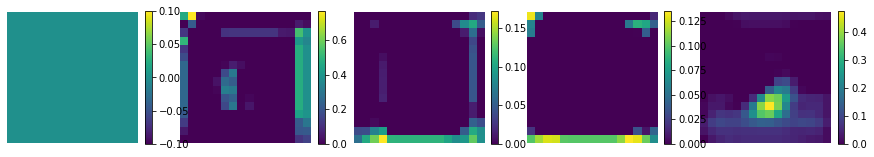

30


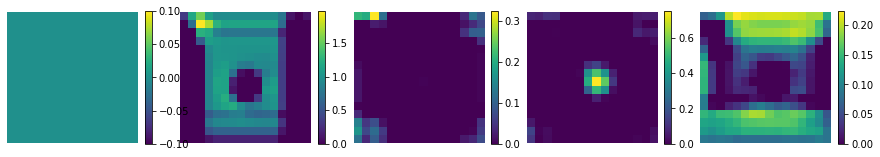

31


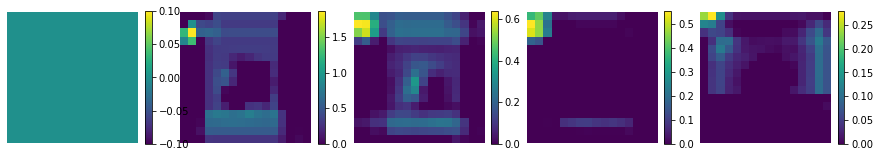

32


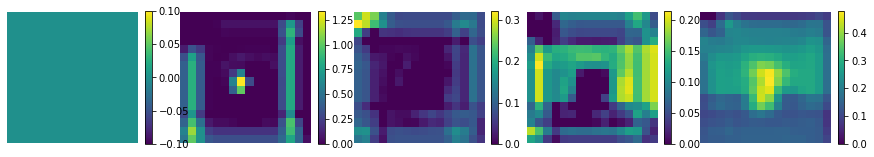

33


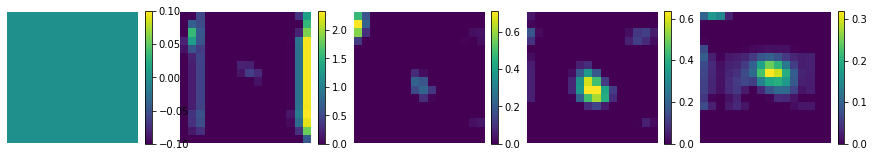

34


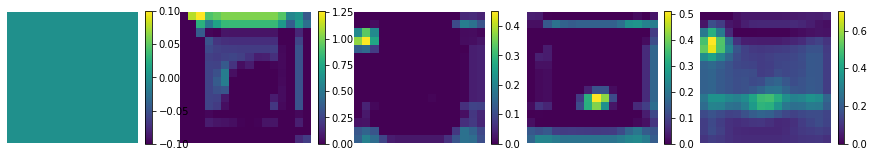

35


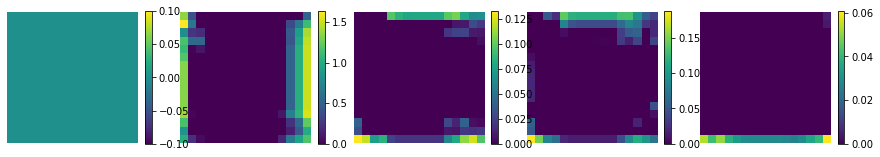

36


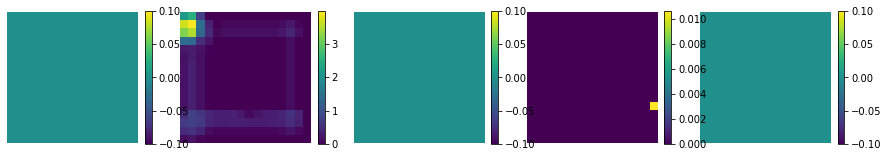

37


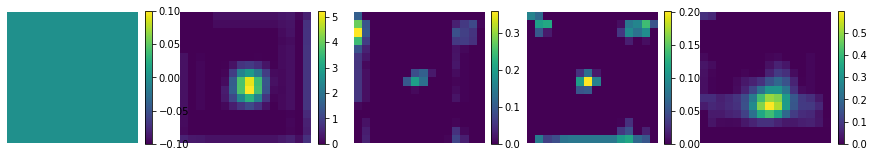

38


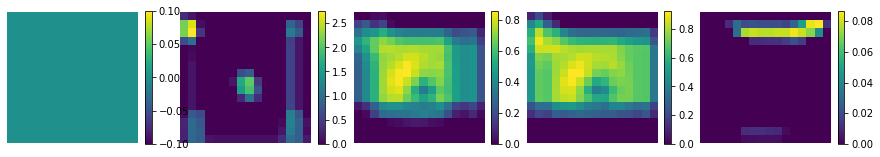

39


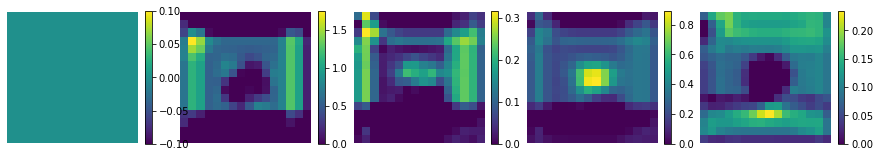

40


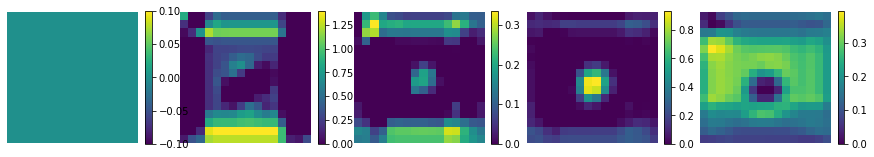

41


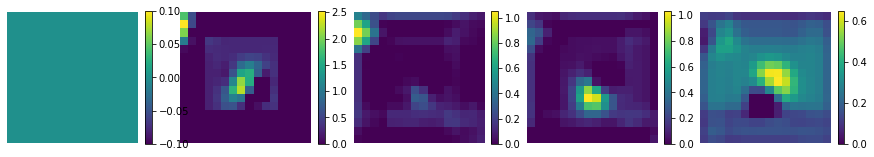

42


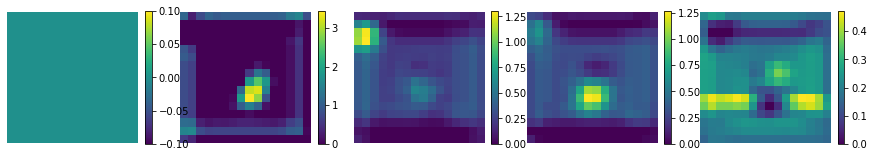

43


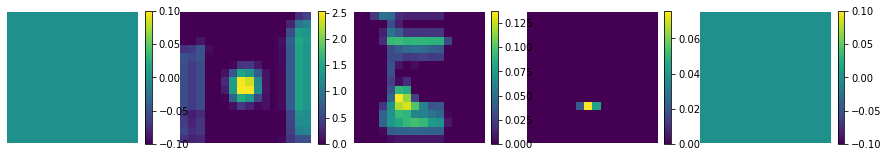

44


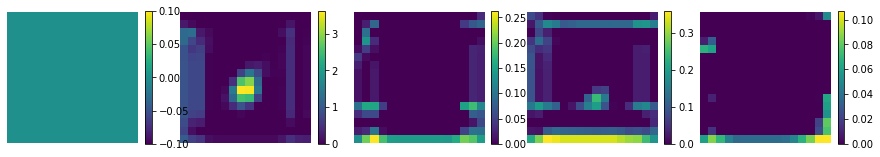

45


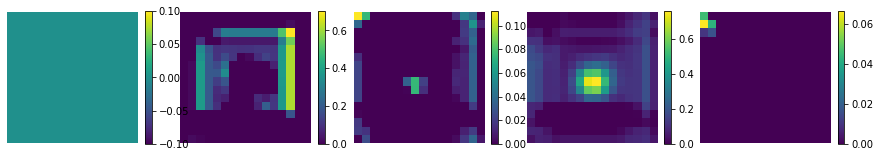

46


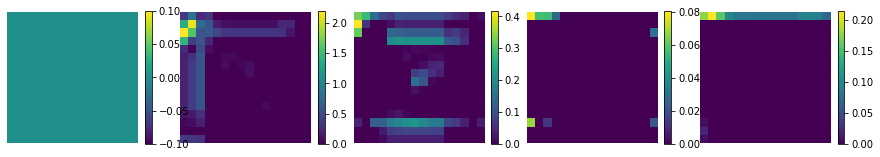

47


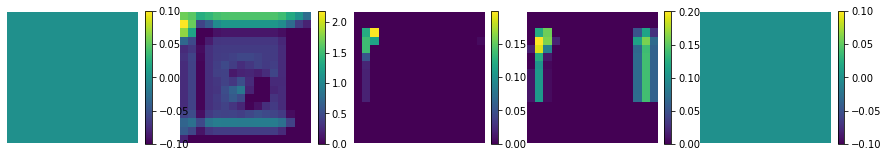

48


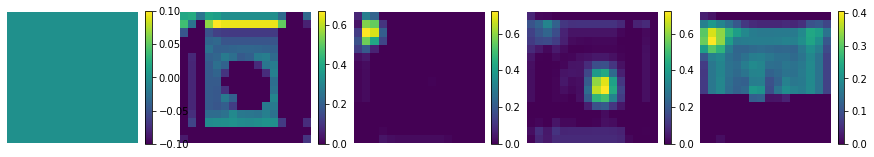

49


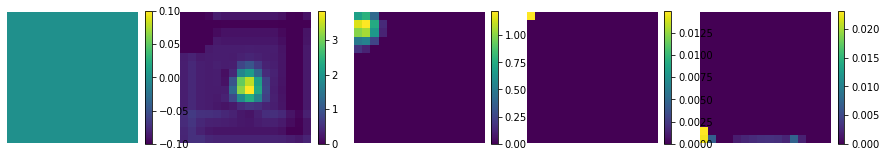

50


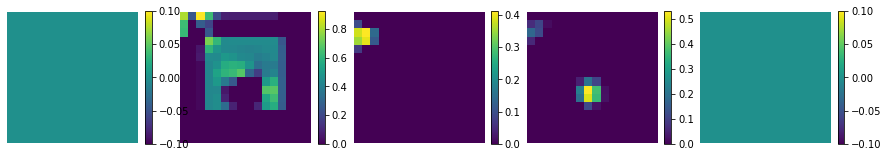

51


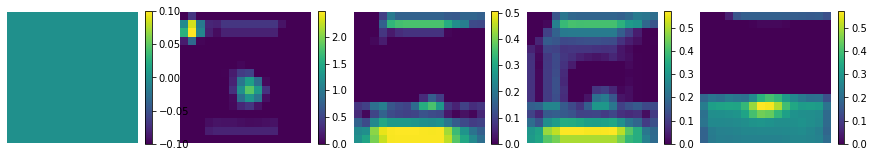

52


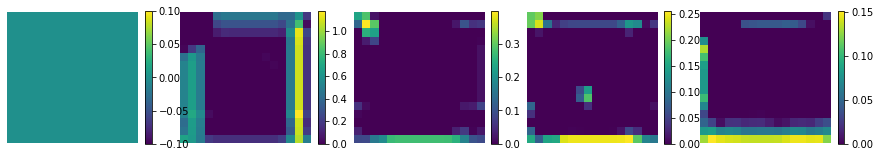

53


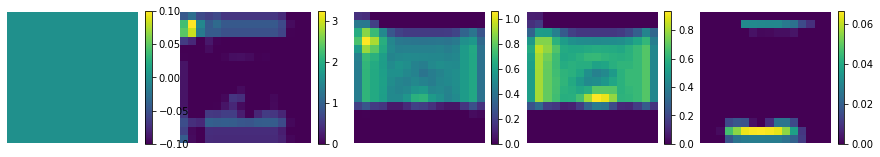

54


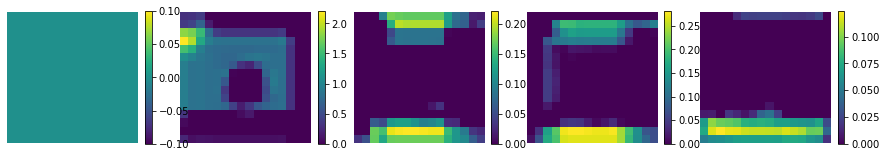

55


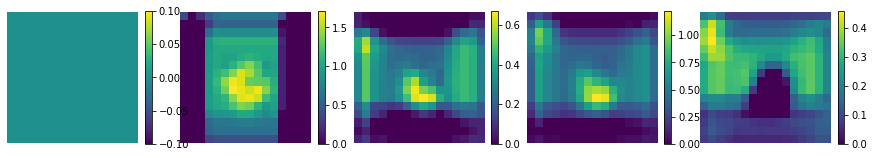

56


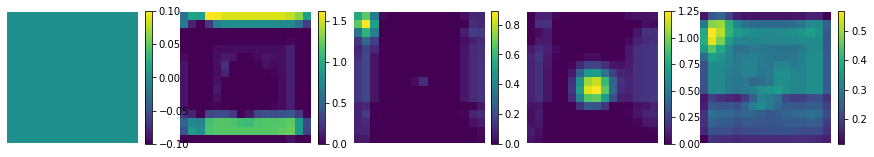

57


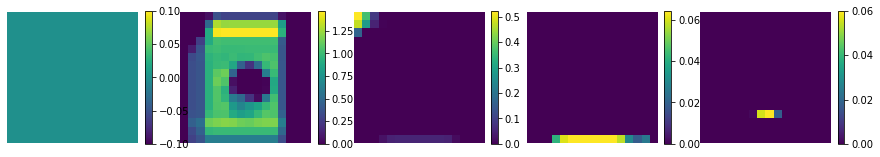

58


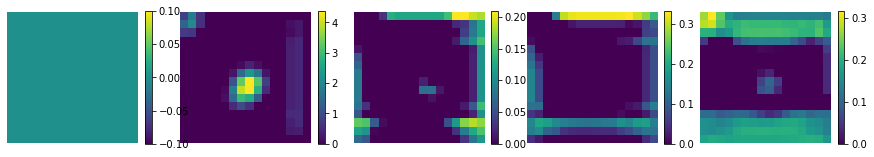

59


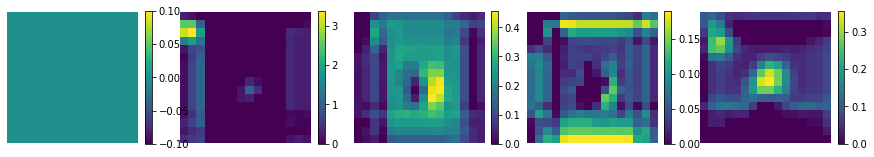

60


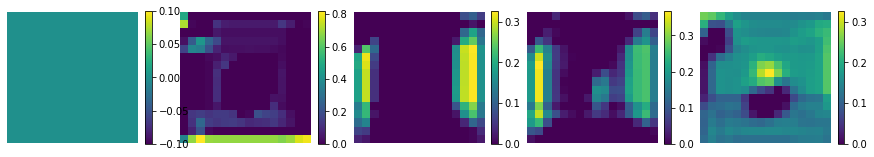

61


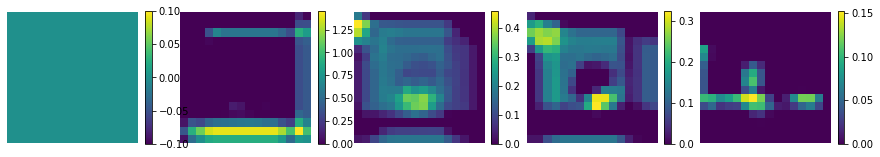

62


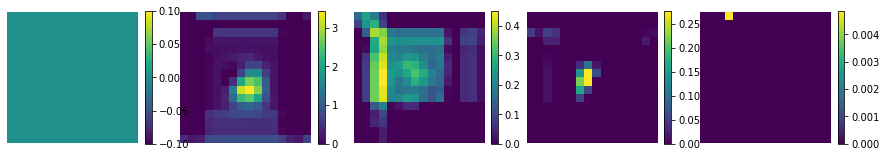

63


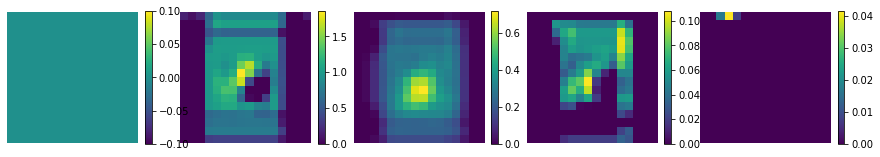

In [29]:
img_, _, pred = evaluate_activations(X=22, R=45, Y=31, pos_x=[5,5], pos_y=[35,35], 
                                     path_vocab_dataset=path_vocab_dataset,
                                     path_model=path_model,
                                     model_file=lst_best_models[0])

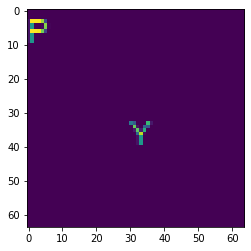

In [30]:
plt.imshow(img_[1])

In [31]:
pred

tensor([[1.0000e+00, 2.0830e-06]], device='cuda:0', grad_fn=<SoftmaxBackward>)

# Remark

We test this model, trained on a different dataset, using the same question. We want to be sure that we are testing systematic generalization in this case too. We load the test & validation questions to be sure.

In [32]:
key=5
vocab_dataset = load_vocab(join(data_path[key], 'vocab.json'))

question_vl_path = join(data_path[key], 'val_questions.h5') 
question_ts_path = join(data_path[key], 'test_questions.h5') 

question_vl = h5py.File(question_vl_path, 'r')
question_ts = h5py.File(question_ts_path, 'r')

question_vl_array = np.array(question_vl['questions'])
question_ts_array = np.array(question_ts['questions'])

In [33]:
set_ = set(range(0, qs.shape[0]))
print(set_.intersection(set([1,2])))

NameError: name 'qs' is not defined

In [ ]:
x=31 
r=45
y=22

qs = question_vl_array  # check for both training and validation
set_ = set(range(0, qs.shape[0]))
for i_, q_ in enumerate([x,r,y]):
    set_ = set_.intersection(set(np.where(qs[:, i_] == q_)[0]))
    
print(set_)  # index related to the question [x,r,y]

## Reading the output 

[1, 0] encodes False   
[0, 1] is True

In [ ]:
ce = torch.nn.CrossEntropyLoss()
loss = ce(torch.tensor([[0.1,0.9]]), torch.tensor([0])).item()
print(loss)
loss = ce(torch.tensor([[0.99,0.01]]), torch.tensor([0])).item()
print(loss)

In [ ]:
tree_scores = tree_model.classifier(res[:,-1,:,:,:])
output_probs_tree  = F.softmax(tree_scores, dim=1)
print(output_probs_tree)

In [ ]:
tmp = res[:, -1]
for k_ in tree_model.classifier:
    print([p_.shape for p_ in k_.parameters()])
    tmp = k_(tmp)
    print(tmp.shape)